In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import os
import seaborn as sn
from lifelines.fitters.kaplan_meier_fitter import KaplanMeierFitter
from lifelines import CoxPHFitter
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import KFold
import lifelines
import models
import torch
from pycox.models import DeepHitSingle
import warnings
import utils

import torchtuples as tt
from pycox.models import CoxPH
from pycox.evaluation import EvalSurv
from ray import tune

pd.set_option('display.max_columns', None)


In [3]:
import sksurv
print(sksurv.__version__)
df, y = sksurv.datasets.load_whas500()
df = df.join(pd.DataFrame(y))
# print how many null values are in each column?
df

0.19.0


,afb,age,av3,bmi,chf,cvd,diasbp,gender,hr,los,miord,mitype,sho,sysbp,fstat,lenfol
0,1,83.0,0,25.54051,0,1,78.0,0,89.0,5.0,1,0,0,152.0,False,2178.0
1,0,49.0,0,24.02398,0,1,60.0,0,84.0,5.0,0,1,0,120.0,False,2172.0
2,0,70.0,0,22.14290,0,0,88.0,1,83.0,5.0,0,1,0,147.0,False,2190.0
3,0,70.0,0,26.63187,1,1,76.0,0,65.0,10.0,0,1,0,123.0,True,297.0
4,0,70.0,0,24.41255,0,1,85.0,0,63.0,6.0,0,1,0,135.0,False,2131.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,1,76.0,0,27.96454,0,1,88.0,1,68.0,1.0,0,1,0,112.0,True,10.0
496,0,76.0,0,24.26862,0,1,96.0,1,88.0,3.0,0,0,0,208.0,False,662.0
497,1,57.0,0,42.13576,0,1,74.0,1,123.0,3.0,0,0,0,120.0,False,725.0
498,0,67.0,0,27.40905,0,1,62.0,0,59.0,1.0,0,1,0,112.0,False,532.0


In [4]:
df = utils.get_unprocessed_dataset()[0]
df.head()

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "C:\Users\User\AppData\Roaming\Python\Python310\site-packages\IPython\core\interactiveshell.py", line 3433, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\User\AppData\Local\Temp\ipykernel_11496\1232442534.py", line 1, in <module>
    df = utils.get_unprocessed_dataset()[0]
AttributeError: module 'utils' has no attribute 'get_unprocessed_dataset'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\User\AppData\Roaming\Python\Python310\site-packages\IPython\core\interactiveshell.py", line 2052, in showtraceback
    stb = self.InteractiveTB.structured_traceback(
  File "C:\Users\User\AppData\Roaming\Python\Python310\site-packages\IPython\core\ultratb.py", line 1118, in structured_traceback
    return FormattedTB.structured_traceback(
  File "C:\Users\User\AppData\Roaming\Python\Python310\site-packages\IPython\core\ultratb.py", line 1012, in s

## Test set

In [5]:
df_clear, event_col, duration_col = utils.get_veterans_lugn_cancer(missing_values_strategy="mean")
df_train, df_test = utils.split_dataset(df_clear)
df_train

,Age_in_years,Karnofsky_score,Months_from_Diagnosis,Status,Survival_in_days,Celltype_large,Celltype_smallcell,Celltype_squamous,Prior_therapy_yes,Treatment_test
10,81.0,60.0,4.0,True,42.0,0,0,1,0,0
130,49.0,60.0,11.0,True,43.0,1,0,0,1,1
51,64.0,80.0,5.0,True,162.0,0,0,0,0,0
11,63.0,40.0,58.0,True,8.0,0,0,1,1,0
114,70.0,60.0,3.0,True,73.0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...
71,48.0,80.0,3.0,False,87.0,0,0,1,0,1
106,67.0,40.0,8.0,True,29.0,0,1,0,0,1
14,48.0,70.0,11.0,True,11.0,0,0,1,1,0
92,62.0,30.0,2.0,True,13.0,0,1,0,0,1


<AxesSubplot: >

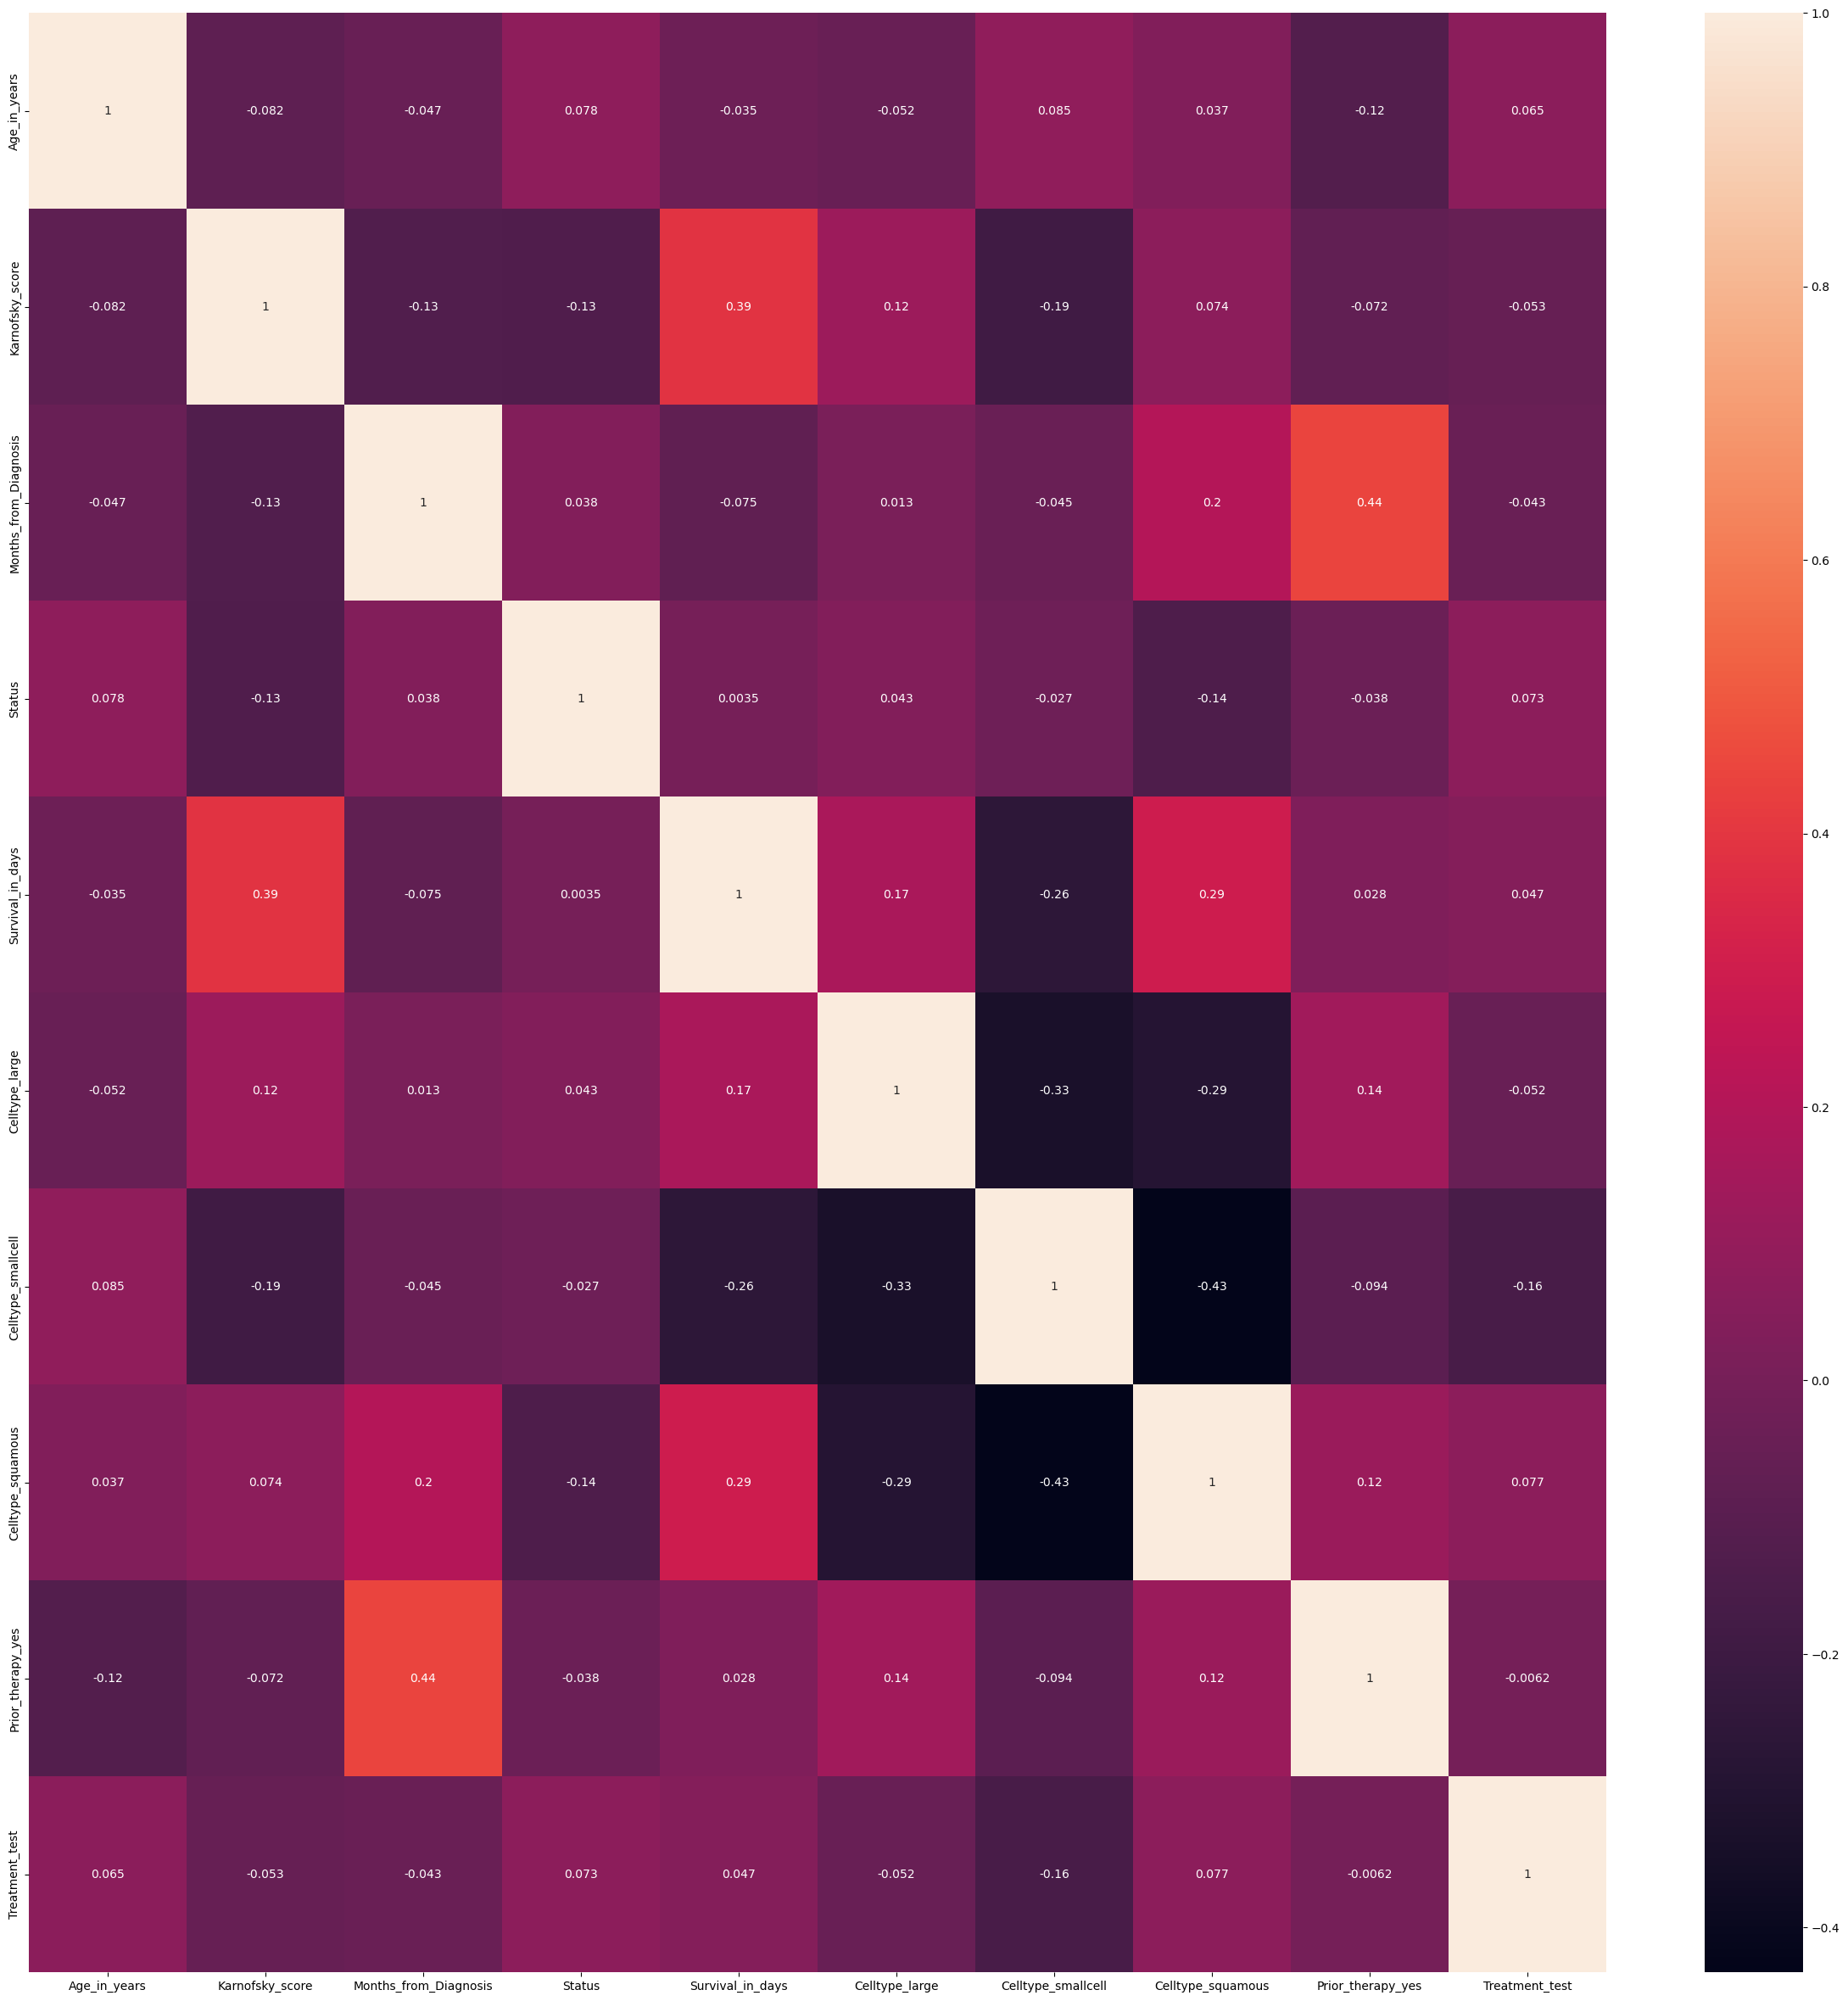

In [6]:
plt.figure(figsize=(30, 30))
sn.heatmap(df_train.corr(), annot=True)

In [7]:
X = df_train.drop([event_col, duration_col], axis = 1)
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
  
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                          for i in range(len(X.columns))]
  
print(vif_data)

                 feature        VIF
0           Age_in_years  11.638202
1        Karnofsky_score   7.485057
2  Months_from_Diagnosis   2.458340
3         Celltype_large   1.962723
4     Celltype_smallcell   2.629046
5      Celltype_squamous   2.480138
6      Prior_therapy_yes   1.861661
7         Treatment_test   2.077747


In [8]:
num_folds = 10
kf = KFold(n_splits=num_folds, shuffle=True, random_state=0)
mean_concordance = 0.0
models = []
oof_preds = np.zeros((len(df_train), 1))
for i, (train_index, test_index) in enumerate(kf.split(df_train)):
    train = df_train.iloc[train_index]
    valid = df_train.iloc[test_index]

    cph = CoxPHFitter(penalizer=0.1)
    cph.fit(train, duration_col = duration_col, event_col = event_col)
    concordance_index = cph.score(valid, scoring_method="concordance_index")

    print("Fold: ", i, "concordance index: ", concordance_index)
    
    mean_concordance += concordance_index

    oof_preds[test_index] = cph.predict_partial_hazard(valid).values.reshape(-1, 1)

    models.append(cph)
print("oof concordance index: ", lifelines.utils.concordance_index(df_train[duration_col].values, -oof_preds, df_train[event_col].values))


Fold:  0 concordance index:  0.7659574468085106
Fold:  1 concordance index:  0.8205128205128205
Fold:  2 concordance index:  0.8727272727272727
Fold:  3 concordance index:  0.6545454545454545
Fold:  4 concordance index:  0.7407407407407407
Fold:  5 concordance index:  0.6363636363636364
Fold:  6 concordance index:  0.8372093023255814
Fold:  7 concordance index:  0.6
Fold:  8 concordance index:  0.6363636363636364
Fold:  9 concordance index:  0.6976744186046512
oof concordance index:  0.7267808836789901


In [9]:
cph = CoxPHFitter(penalizer=0.1)
cph.fit(train, duration_col = duration_col, event_col = event_col)
concordance_index = cph.score(valid, scoring_method="concordance_index")

cph.print_summary()

<lifelines.CoxPHFitter: fitted with 99 total observations, 7 right-censored observations>
             duration col = 'Survival_in_days'
                event col = 'Status'
                penalizer = 0.1
                 l1 ratio = 0.0
      baseline estimation = breslow
   number of observations = 99
number of events observed = 92
   partial log-likelihood = -313.43
         time fit was run = 2023-05-20 06:09:10 UTC

---
                        coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                     
Age_in_years           -0.01       0.99       0.01            -0.03             0.01                 0.97                 1.01
Karnofsky_score        -0.03       0.97       0.01            -0.04            -0.02                 0.96                 0.98
Months_from_Diagnosis   0.01       1.01       0.01            -0.02             0.04                 0.98                 1.04
Celltype_large         -0.61       0.54       0.31            -1.22            -0.00                 0.30                 1.00
Celltype_smallcell     -0.01       0.99       0.28            -0.56             0.54                 0.57                 1.71
Celltype_squamous      -0.94       0.39       0.29            -1.51            -0.37                 0.22                 0.69
Prior_therapy_yes      -0.09       0.92       0.26            -0.59             0.41                 0.56                 1.51
Treatment_test          0.21       1.23       0.22            -0.22             0.64                 0.80                 1.90

                        cmp to     z      p   -log2(p)
covariate                                             
Age_in_years              0.00 -1.06   0.29       1.79
Karnofsky_score           0.00 -4.74 <0.005      18.84
Months_from_Diagnosis     0.00  0.87   0.39       1.37
Celltype_large            0.00 -1.97   0.05       4.35
Celltype_smallcell        0.00 -0.03   0.98       0.04
Celltype_squamous         0.00 -3.21 <0.005       9.57
Prior_therapy_yes         0.00 -0.34   0.73       0.45
Treatment_test            0.00  0.94   0.35       1.53
---
Concordance = 0.76
Partial AIC = 642.85
log-likelihood ratio test = 41.21 on 8 df
-log2(p) of ll-ratio test = 19.00

In [10]:
predictions = np.zeros(df_test.shape[0])
for model in models:
    predictions -= model.predict_partial_hazard(df_test)
predictions /= num_folds
lifelines.utils.concordance_index(df_test[duration_col], predictions, event_observed=df_test[event_col])

0.6813186813186813

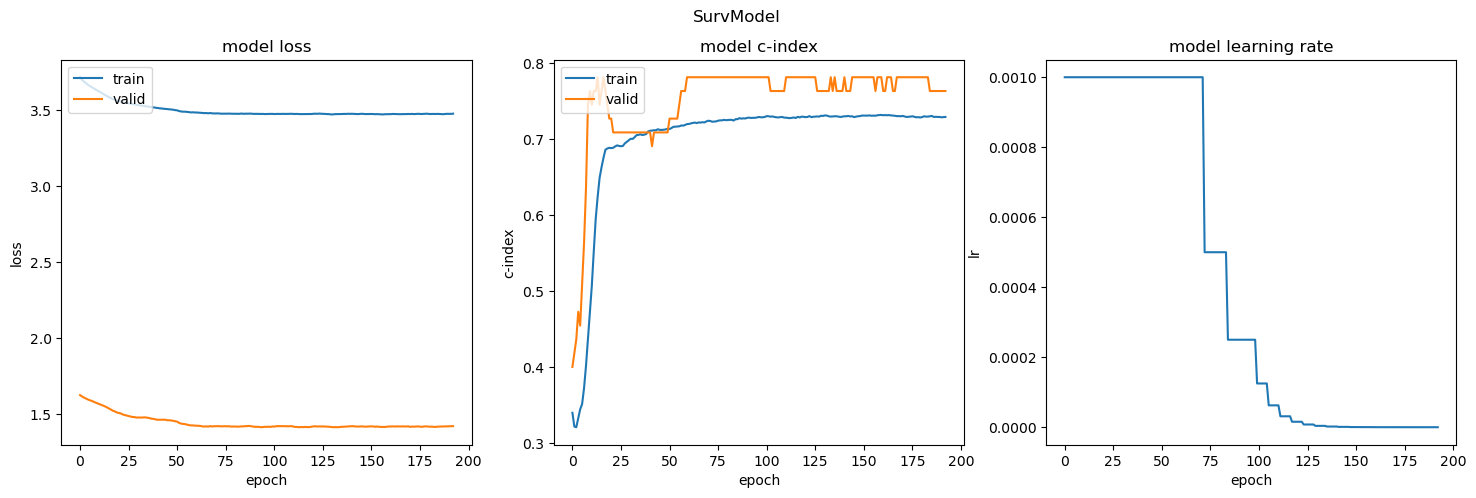

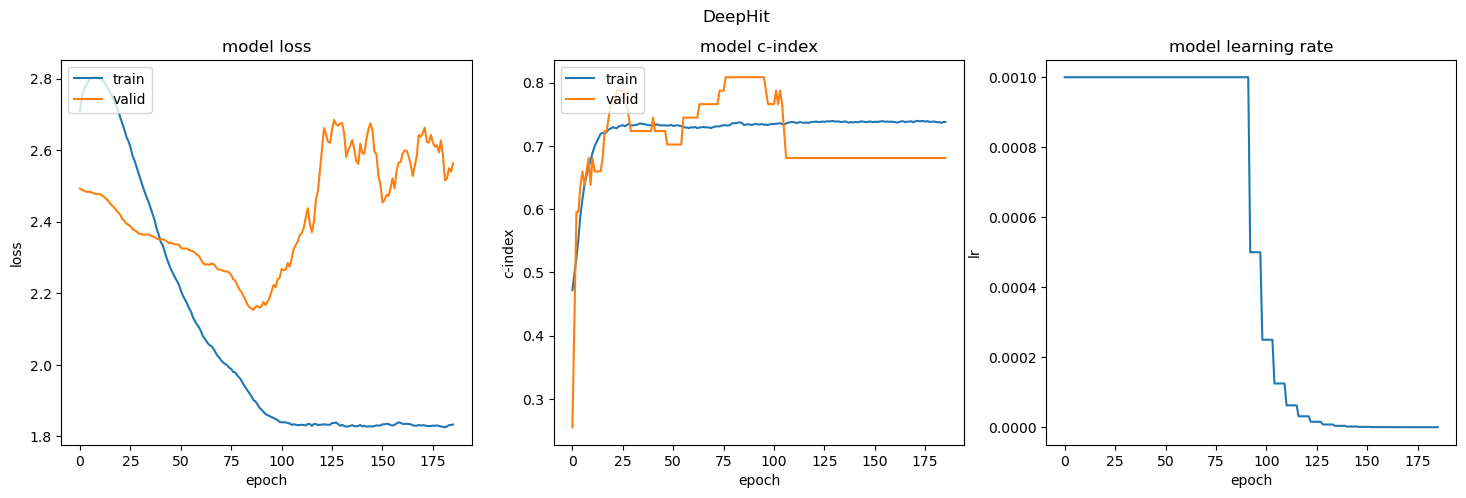

Fold 0
package concordance 0.5476190476190477, surv concordance 0.7818181818181819, hit concordance 0.8085106382978723


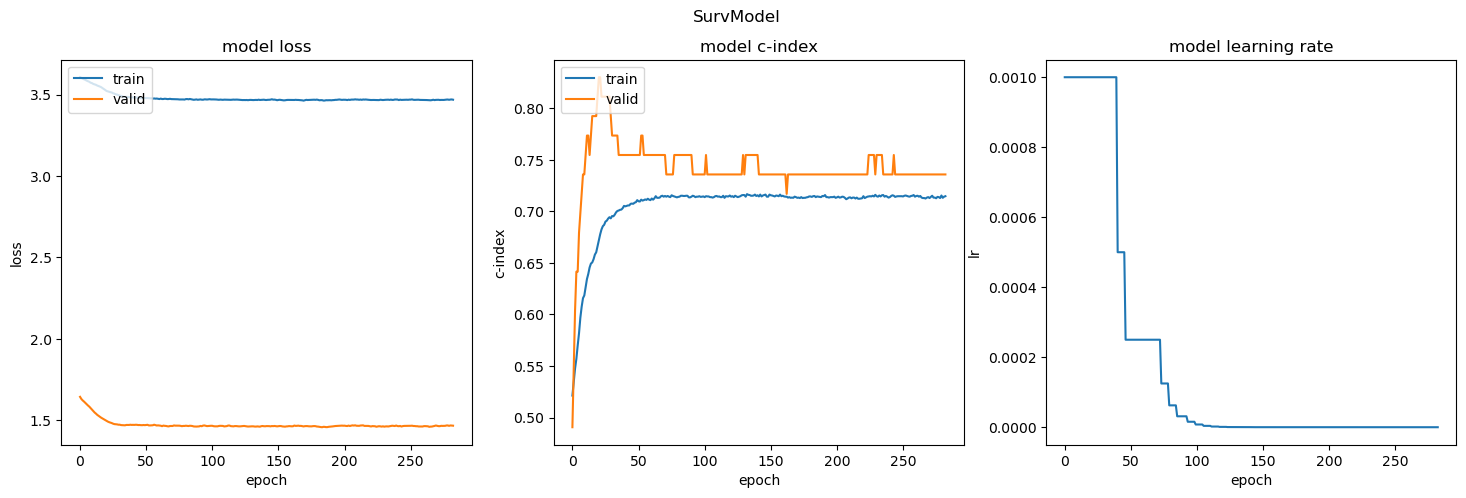

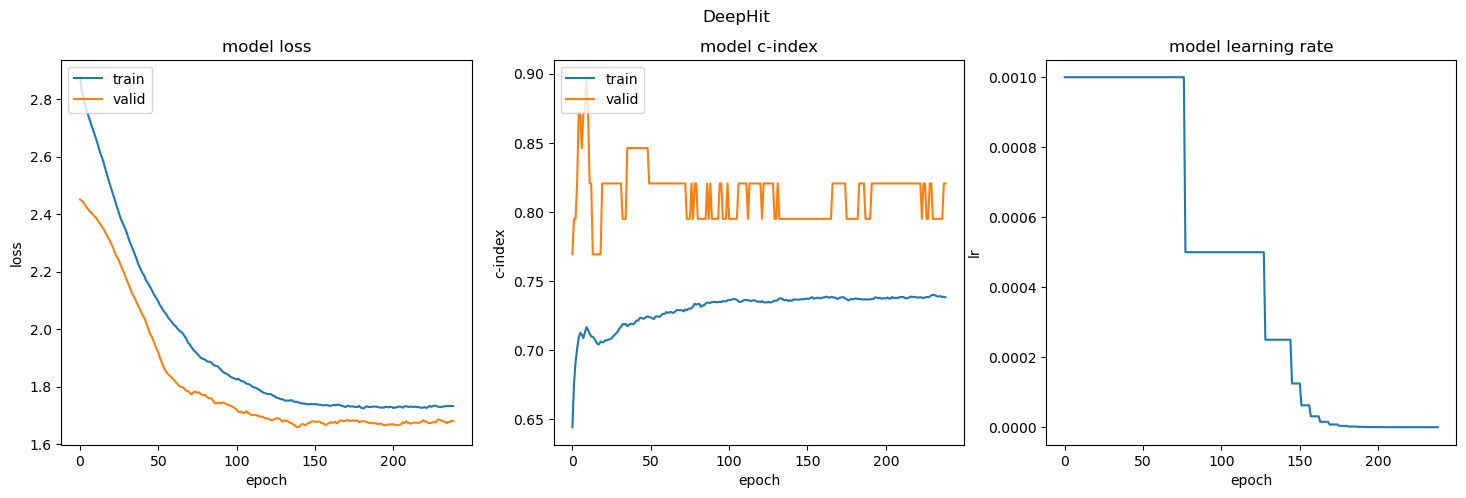

Fold 1
package concordance 0.6923076923076923, surv concordance 0.8301886792452831, hit concordance 0.8974358974358975


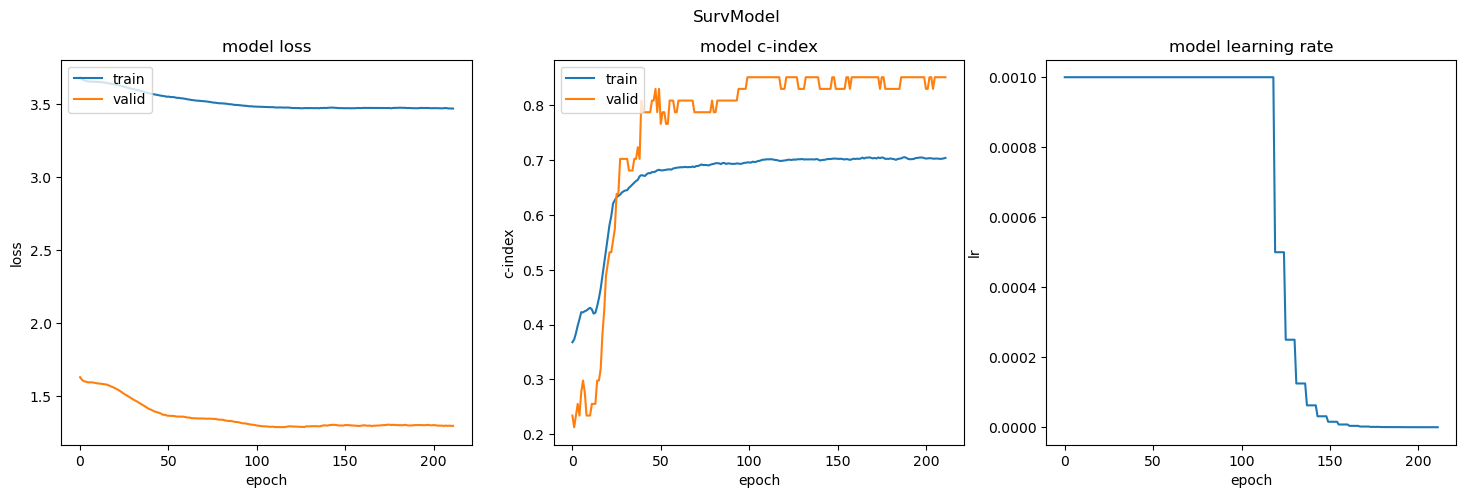

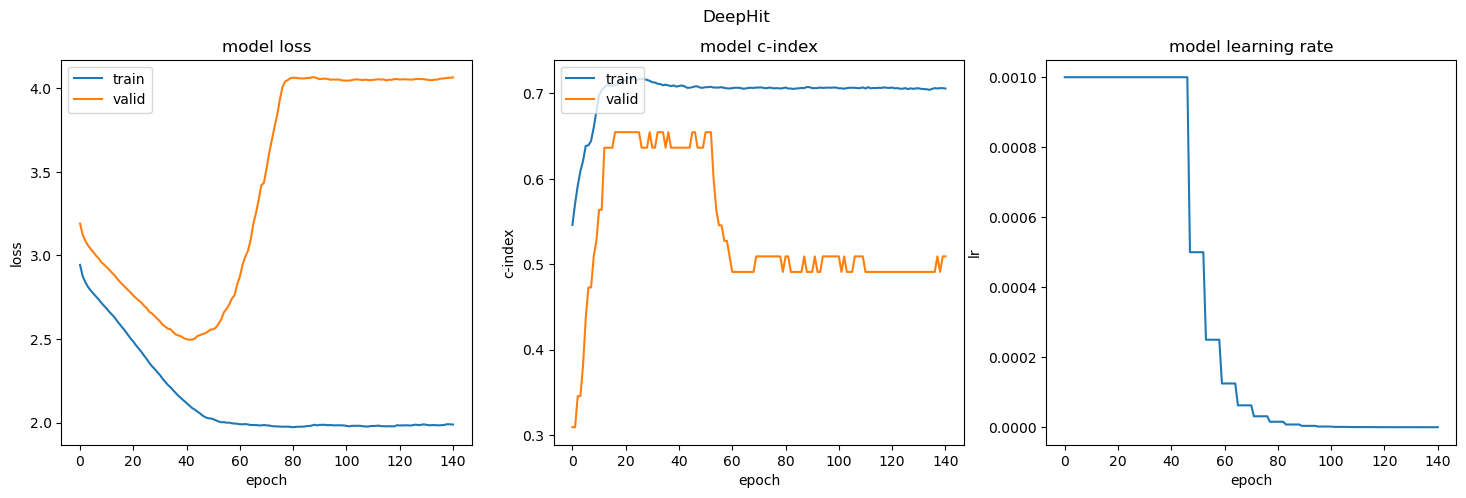

Fold 2
package concordance 0.85, surv concordance 0.851063829787234, hit concordance 0.6545454545454545


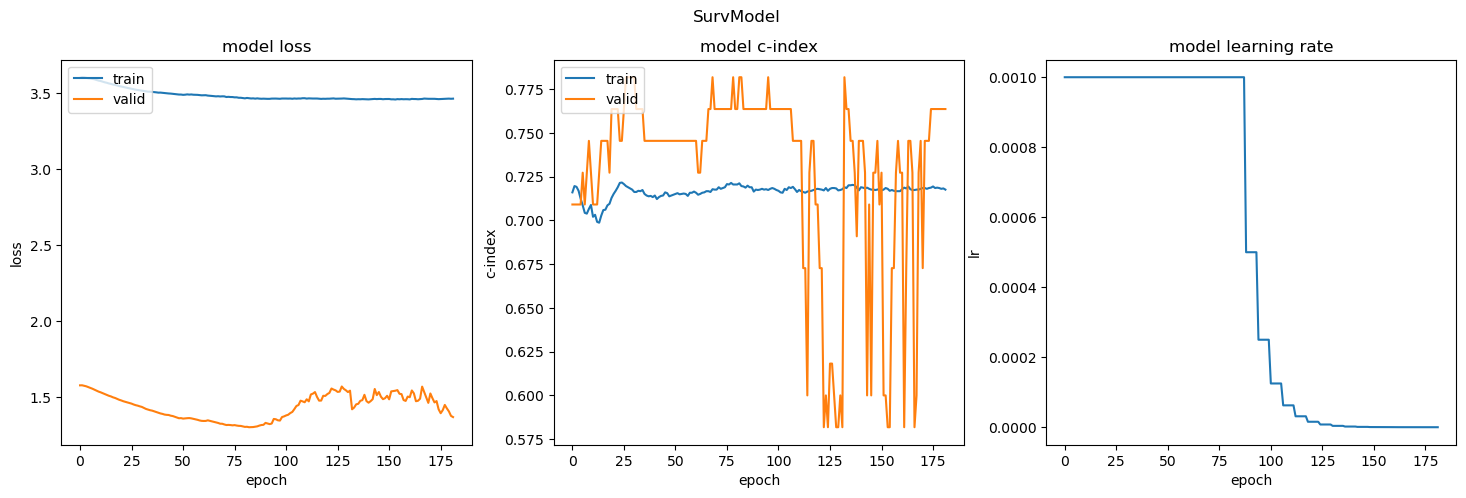

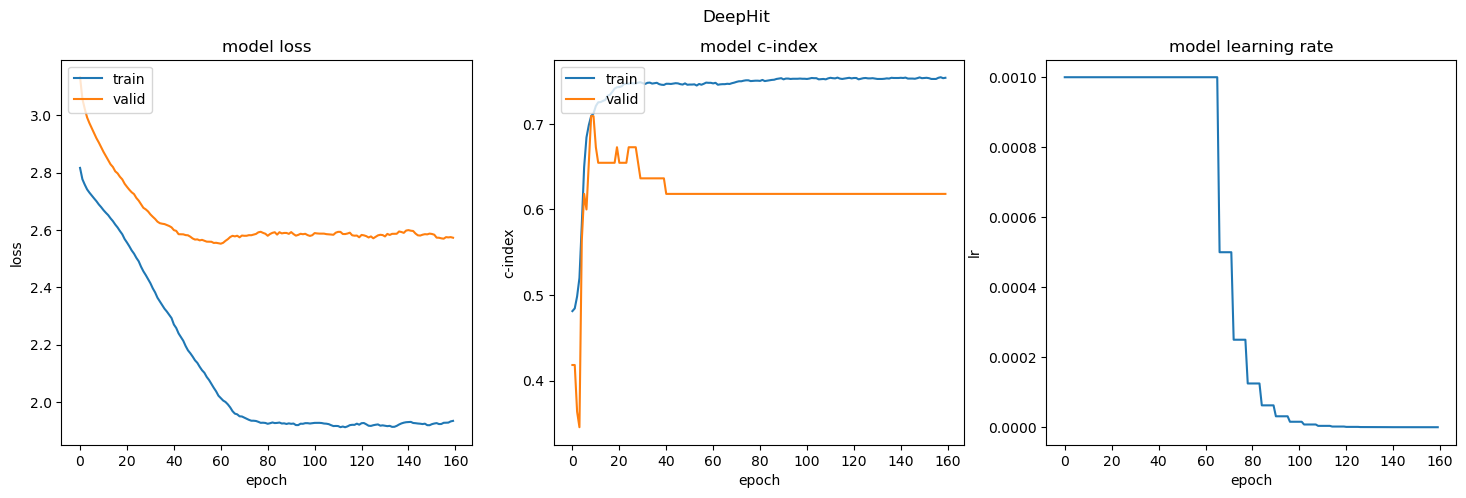

Fold 3
package concordance 0.6666666666666666, surv concordance 0.7818181818181819, hit concordance 0.7090909090909091


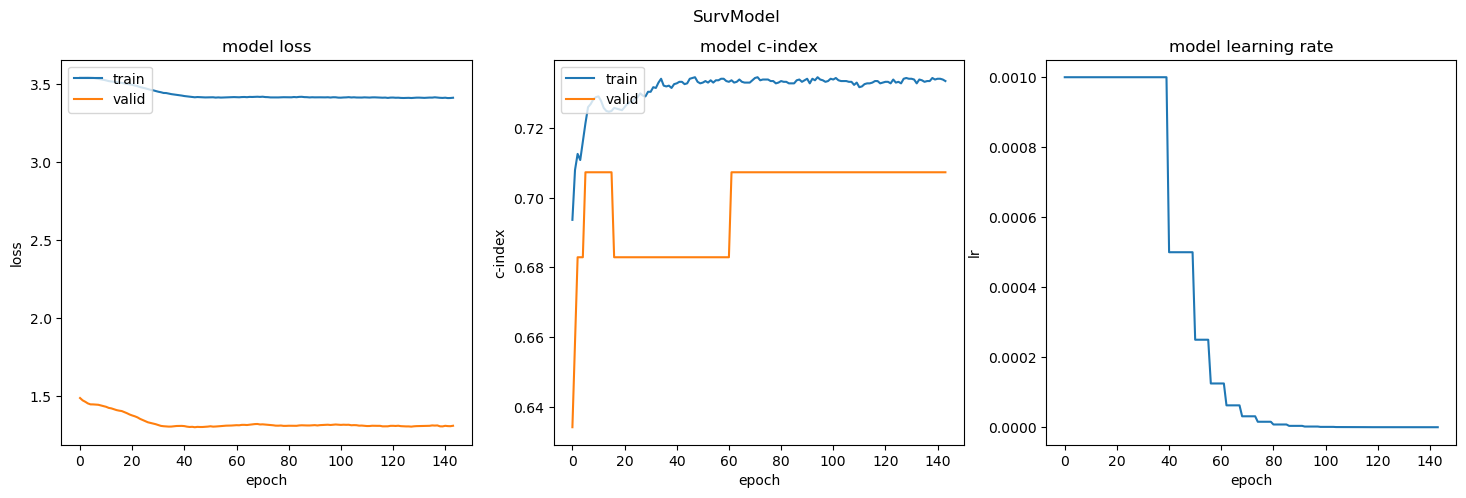

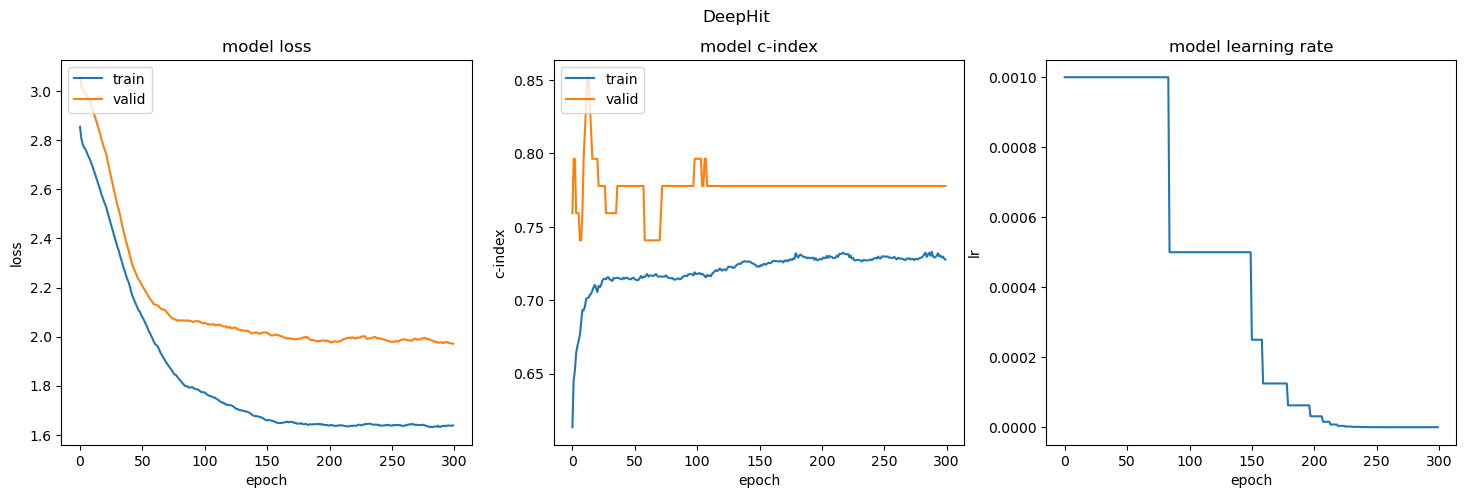

Fold 4
package concordance 0.7659574468085106, surv concordance 0.7073170731707317, hit concordance 0.8518518518518519


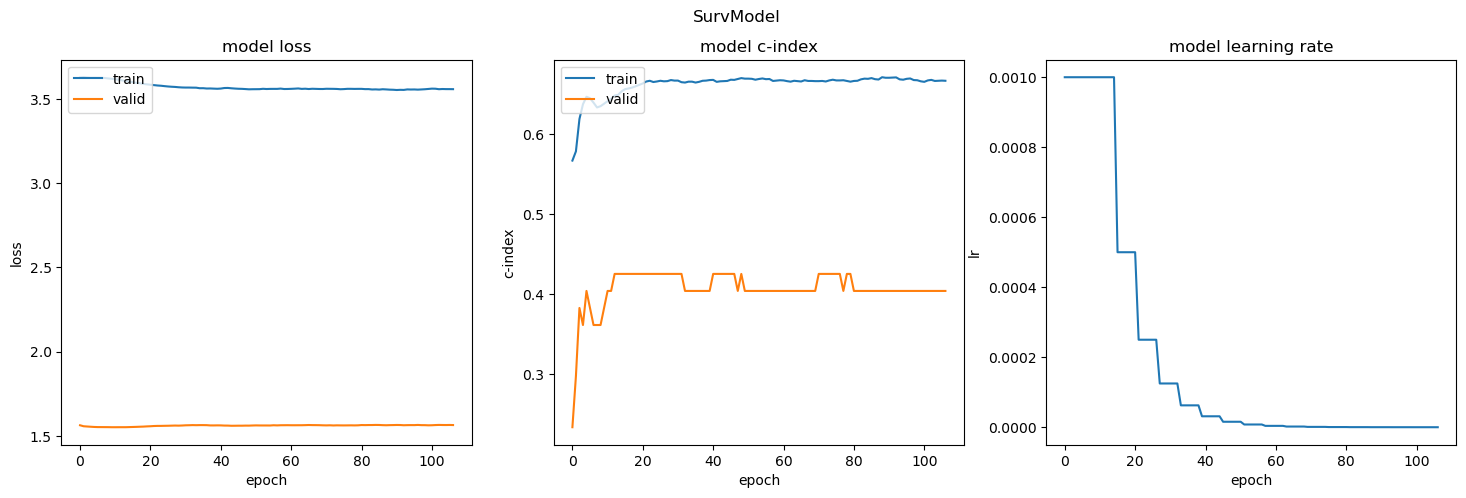

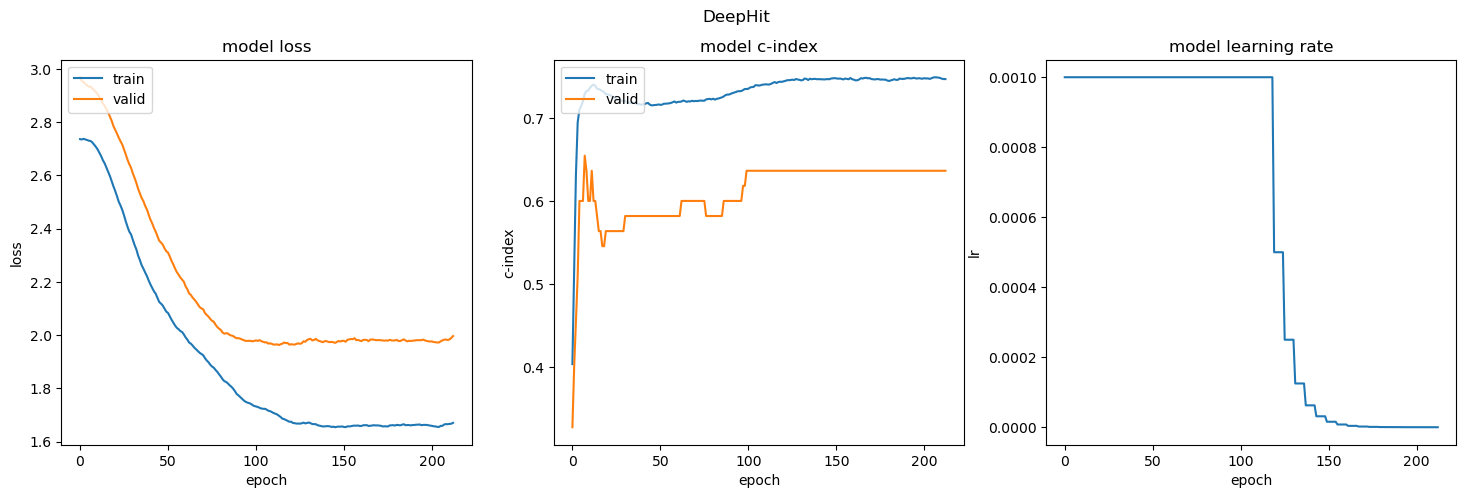

Fold 5
package concordance 0.5, surv concordance 0.425531914893617, hit concordance 0.6545454545454545


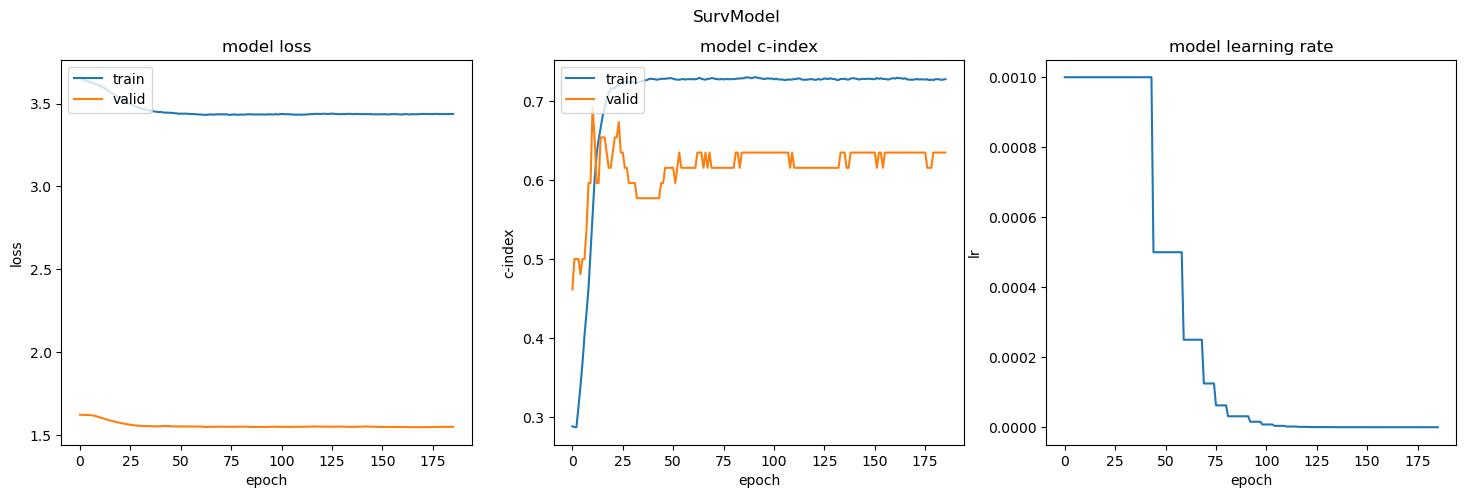

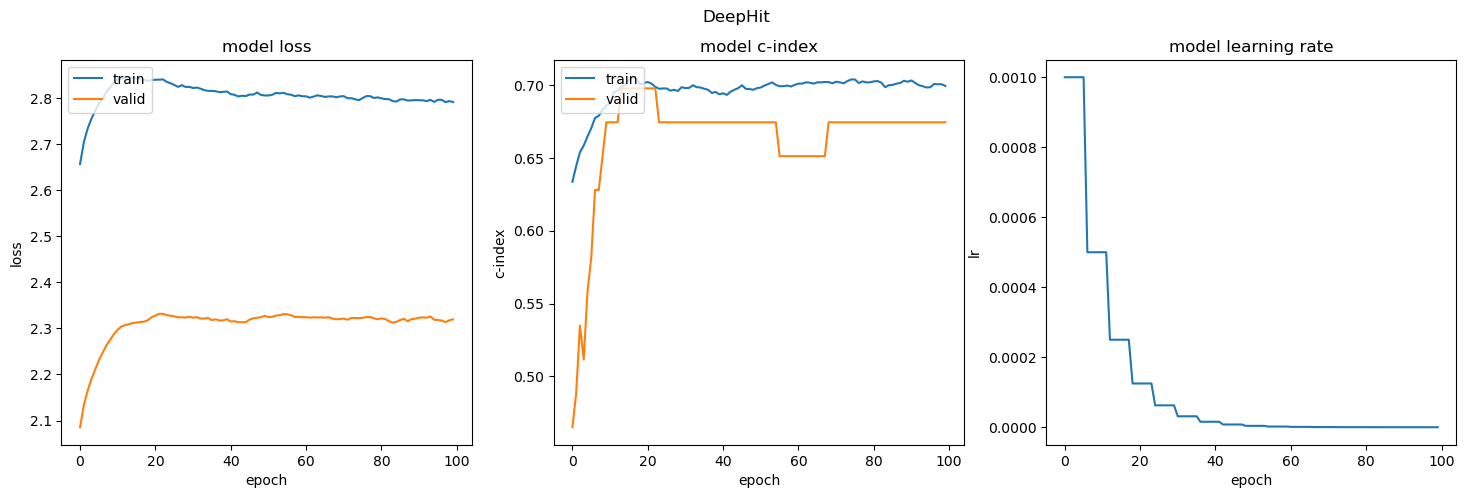

Fold 6
package concordance 0.8823529411764706, surv concordance 0.6923076923076923, hit concordance 0.6976744186046512


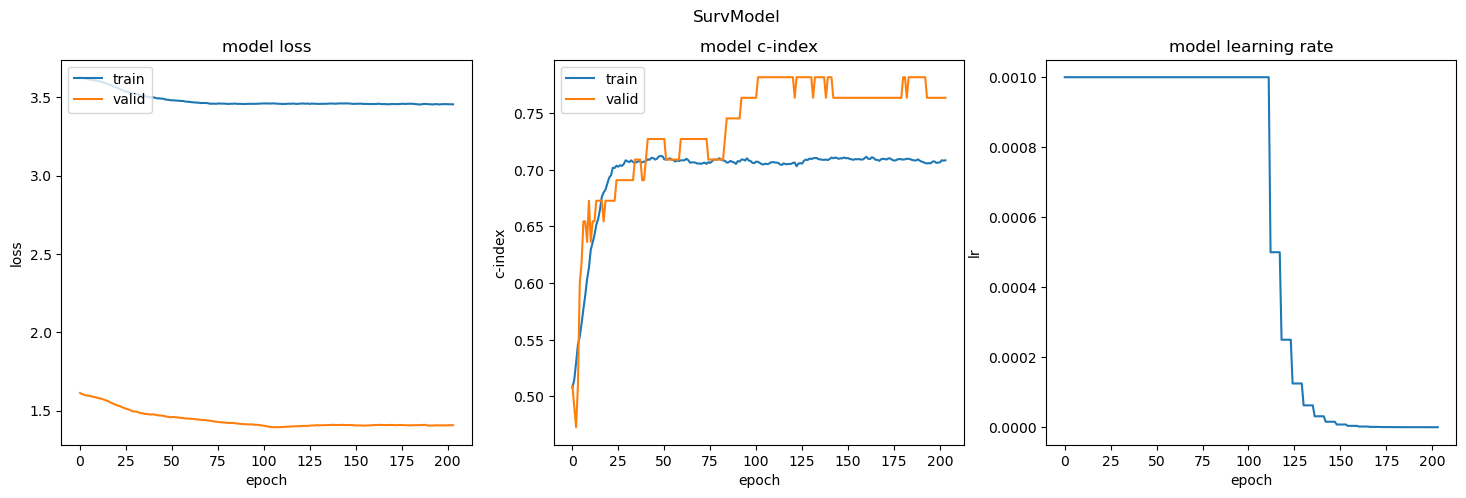

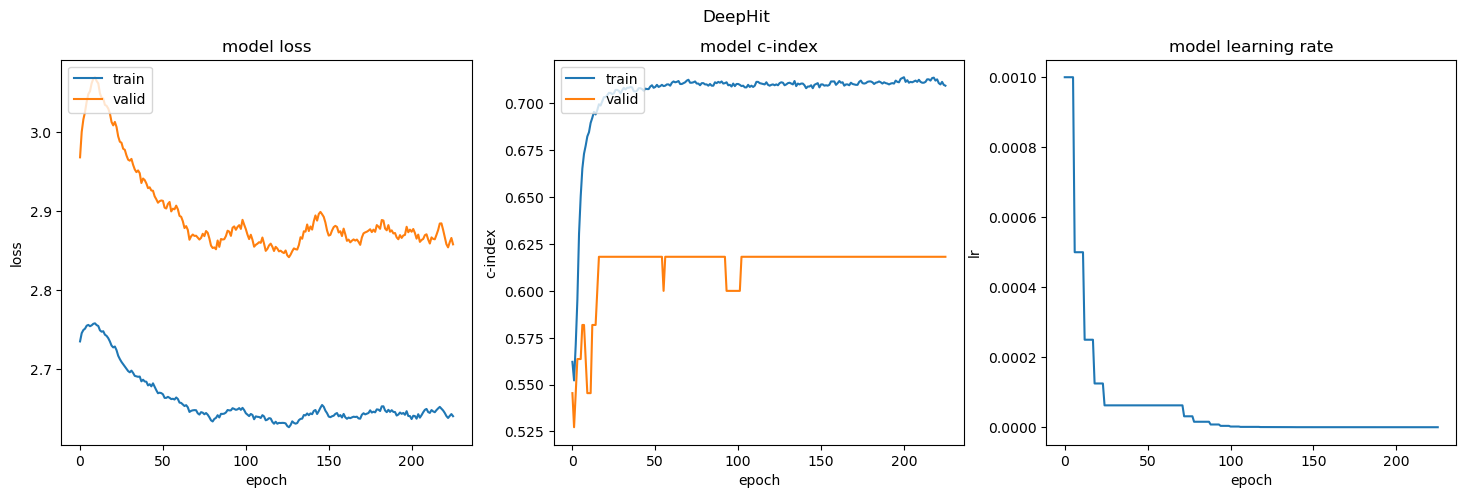

Fold 7
package concordance 0.8181818181818182, surv concordance 0.7818181818181819, hit concordance 0.6181818181818182


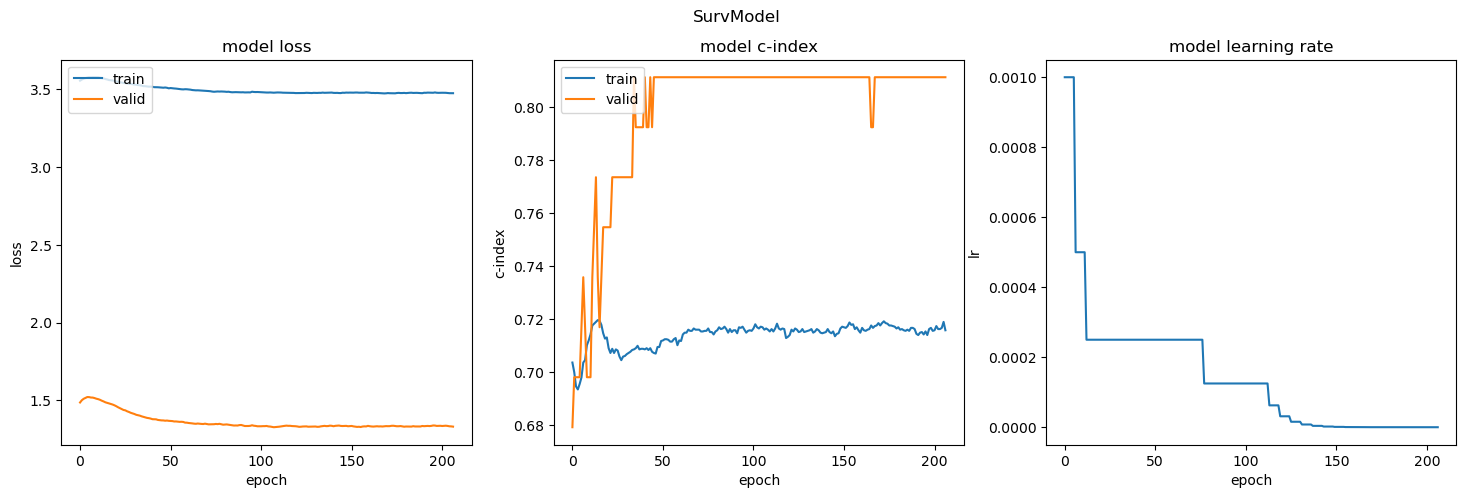

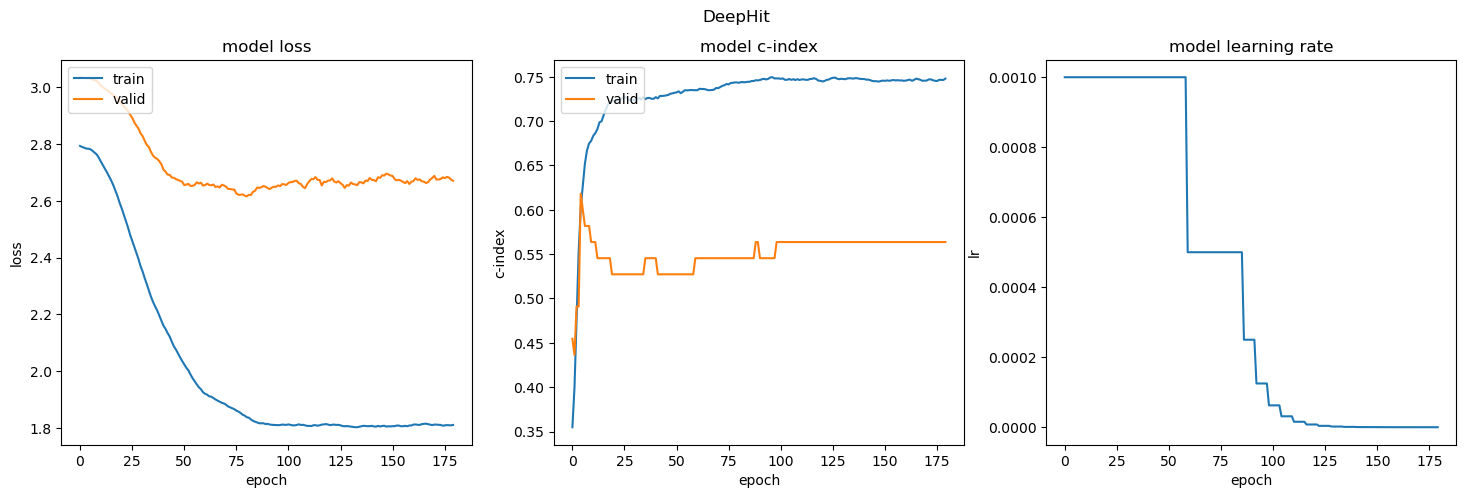

Fold 8
package concordance 0.7111111111111111, surv concordance 0.8113207547169812, hit concordance 0.6181818181818182


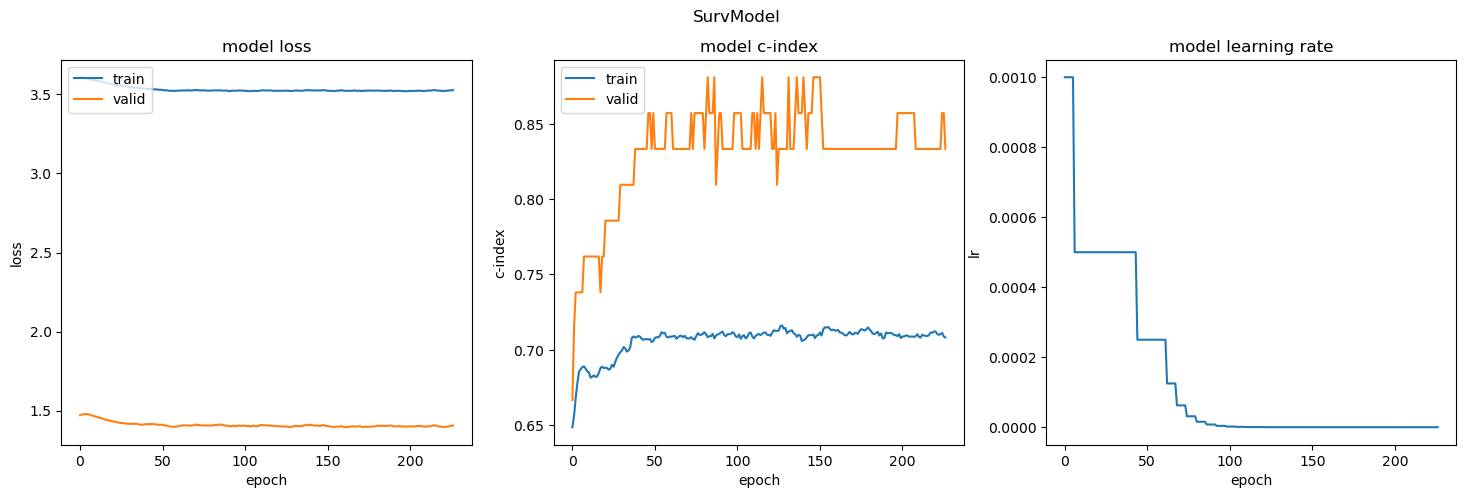

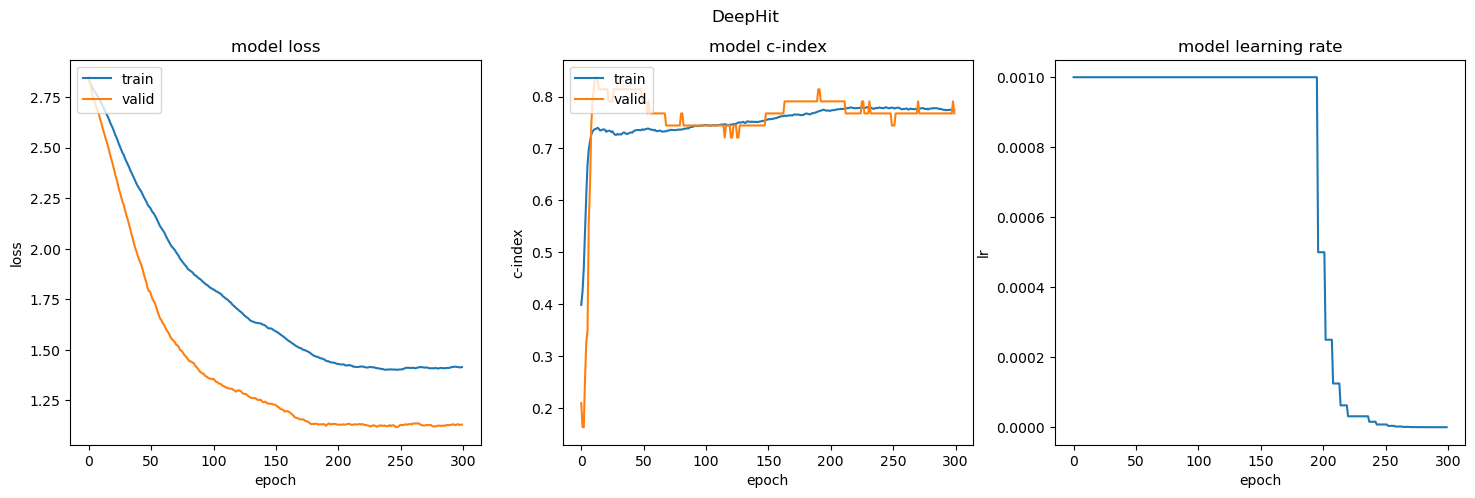

Fold 9
package concordance 0.6470588235294118, surv concordance 0.8809523809523809, hit concordance 0.8372093023255814


C:\Users\User\AppData\Local\Temp\ipykernel_11496\3019573904.py:63: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  hit_oof = hit_model.concordance_index(torch.tensor(oof_preds_hit), (torch.tensor(hit_model.x), torch.tensor(hit_model.events), torch.tensor(hit_model.time), torch.tensor(hit_model.continous_time), torch.tensor(hit_model.mask )))


oof concordance, hit 0.6613165013525699, surv 0.7110910730387737 


In [11]:
from models import SurvModel, DeepHitModel
import torch
from pycox.models import DeepHitSingle
import warnings
import losses
import matplotlib.pyplot as plt
warnings.simplefilter(action='ignore', category=FutureWarning)


TIME_BINS = 20
BATCH_SIZE = 99999

oof_preds_surv = np.zeros((df_train.shape[0], 1))
oof_preds_hit = np.zeros((df_train.shape[0], TIME_BINS))

for i, (train_index, test_index) in enumerate(kf.split(df_train)):

    train = df_clear.iloc[train_index]
    valid = df_clear.iloc[test_index]

    model = SurvModel(df_train.copy(), batch_size=BATCH_SIZE, events_col=event_col, time_col=duration_col, layers = [16,16,16,16], residual=True)
    
    history_surv = model.fit(epochs=300, lr=0.001, verbose=False, train_index=train_index, valid_index=test_index)
    oof_preds_surv[test_index] = model.predict(test_index)
    utils.plot_history(history_surv, 'SurvModel')

    hit_model = DeepHitModel(df_train.copy(), batch_size=BATCH_SIZE, events_col=event_col, time_col=duration_col, time_bins=TIME_BINS, interpolation_steps=10, layers = [64] * 3, dropout=0.4)
    history_hit = hit_model.fit(epochs=300, train_index=train_index, valid_index=test_index, lr=0.001, verbose=False)



    oof_preds_hit[test_index] = hit_model.predict(test_index)
    utils.plot_history(history_hit, 'DeepHit')

    num_durations = 10
    labtrans = DeepHitSingle.label_transform(num_durations)

    x = train.drop([event_col, duration_col], axis=1).values.astype('float32')
    y = labtrans.fit_transform(train[duration_col].values, train[event_col].values)
    
    val_x = valid.drop([event_col, duration_col], axis=1).values.astype('float32')
    val_y = labtrans.fit_transform(valid[duration_col].values, valid[event_col].values)


    in_features = x.shape[1]
    num_nodes = [64, 32, 16]
    out_features = num_durations
    batch_norm = True
    dropout = 0.1
    output_bias = False
    net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm, dropout, output_bias = output_bias).float()

    m = DeepHitSingle(net, tt.optim.Adam)
    m.optimizer.set_lr(0.01)
    log = m.fit(x, y, batch_size=BATCH_SIZE, epochs=50, verbose=False)

    surv = m.predict_surv_df(val_x)
    ev = EvalSurv(surv, val_y[0], val_y[1], censor_surv='km')

    print(f'Fold {i}')
    #print(f'loss {losses.negative_likelihood_loss(valid_preds, torch.tensor(valid[duration_col].values, dtype=torch.float))}') 
    print(f'package concordance {ev.concordance_td("antolini")}, surv concordance {np.max(history_surv["val_c_index"])}, hit concordance {np.max(history_hit["val_c_index"])}')
hit_oof = hit_model.concordance_index(torch.tensor(oof_preds_hit), (torch.tensor(hit_model.x), torch.tensor(hit_model.events), torch.tensor(hit_model.time), torch.tensor(hit_model.continous_time), torch.tensor(hit_model.mask )))
surv_oof = model.concordance_index(torch.tensor(oof_preds_surv), (torch.tensor(model.x), torch.tensor(model.events), torch.tensor(model.time)))
print(f'oof concordance, hit {hit_oof}, surv {surv_oof} ')


In [53]:
from models import SurvModel, DeepHitModel
import torch
from pycox.models import DeepHitSingle
import warnings
import losses
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
import gc

def train_hit(config):
    TIME_BINS = config["time_bins"]

    df, event_col, duration_col  = df_func(missing_values_strategy=config["missing_values_strategy"])
    df_train, df_test = utils.split_dataset(df)

    oof_preds_hit = np.zeros((df_train.shape[0], TIME_BINS))
    for i, (train_index, test_index) in enumerate(kf.split(df_train)):        

        hit_model = DeepHitModel(df_train.copy(), events_col=event_col, time_col=duration_col, time_bins=TIME_BINS, interpolation_steps=config["interpolation_steps"]
                                 , layers = [config["layer_size"]] * config["num_layers"], dropout=config["dropout"], residual=True, batch_size=config["batch_size"])
        hit_model.fit(epochs=150, train_index=train_index, valid_index=test_index, lr=config["lr"], verbose=False, track_history=False, weight_decay=config["weight_decay"])
        oof_preds_hit[test_index] = hit_model.predict(test_index)
    

    hit_oof = hit_model.concordance_index(torch.tensor(oof_preds_hit), (torch.tensor(hit_model.x), torch.tensor(hit_model.events), torch.tensor(hit_model.time), torch.tensor(hit_model.continous_time), hit_model.mask))
    hit_oof_loss = losses.deep_hit_loss(torch.tensor(oof_preds_hit), hit_model.mask).detach().numpy()
    del hit_model, oof_preds_hit
    gc.collect()
    tune.report(loss = hit_oof_loss, c_index=hit_oof)

def train_surv(config):
    
    df, event_col, duration_col  = df_func(missing_values_strategy=config["missing_values_strategy"])
    df_train, df_test = utils.split_dataset(df)

    oof_preds_surv = np.zeros((df_train.shape[0], 1))
    for i, (train_index, test_index) in enumerate(kf.split(df_train)):    
        model = SurvModel(df_train.copy(), events_col=event_col, time_col=duration_col, layers = [config["layer_size"]] * config["num_layers"], dropout=config["dropout"],
                            residual=True, batch_size=config["batch_size"])
        model.fit(epochs=150, train_index=train_index, valid_index=test_index, lr=config["lr"], verbose=False, track_history=False, weight_decay=config["weight_decay"])
        
        oof_preds_surv[test_index] = model.predict(test_index)

    surv_oof = model.concordance_index(torch.tensor(oof_preds_surv), (torch.tensor(model.x), torch.tensor(model.events), torch.tensor(model.time)))
    surv_oof_loss = losses.negative_likelihood_loss(torch.tensor(oof_preds_surv), torch.tensor(model.events, dtype=torch.float)).detach().numpy()
    del model, oof_preds_surv
    gc.collect()
    tune.report(loss = surv_oof_loss, c_index=surv_oof)

hit_config = {
    "lr": tune.uniform(1e-4, 1e-1),
    "dropout": tune.uniform(0.1, 0.5),
    "layer_size": tune.choice([16, 32, 64, 128]),
    "num_layers": tune.choice([ 4, 5, 6, 7, 8, 9, 10]),
    "weight_decay": tune.loguniform(1e-4, 1e-1),
    "time_bins": tune.choice([10, 20, 30, 40, 50]),
    "interpolation_steps": tune.choice([5, 10, 15, 20, 25, 30, 35, 40, 45, 50]),
    "batch_size": tune.choice([32, 64, 128, 256, 512, 1024, 99999]),
    "missing_values_strategy": tune.choice(["mean", "median", "drop"])
}

surv_config = {
    "lr": tune.uniform(1e-4, 1e-1),
    "dropout": tune.uniform(0.1, 0.5),
    "layer_size": tune.choice([16, 32, 64, 128]),
    "num_layers": tune.choice([ 4, 5, 6, 7, 8, 9, 10]),
    "weight_decay": tune.loguniform(1e-4, 1e-1),
    "batch_size": tune.choice([32, 64, 128, 256, 512, 1024, 99999]),
    "missing_values_strategy": tune.choice(["mean", "median", "drop"])
}

2023-05-20 09:22:16,225	INFO tune.py:798 -- Total run time: 77.31 seconds (77.28 seconds for the tuning loop).


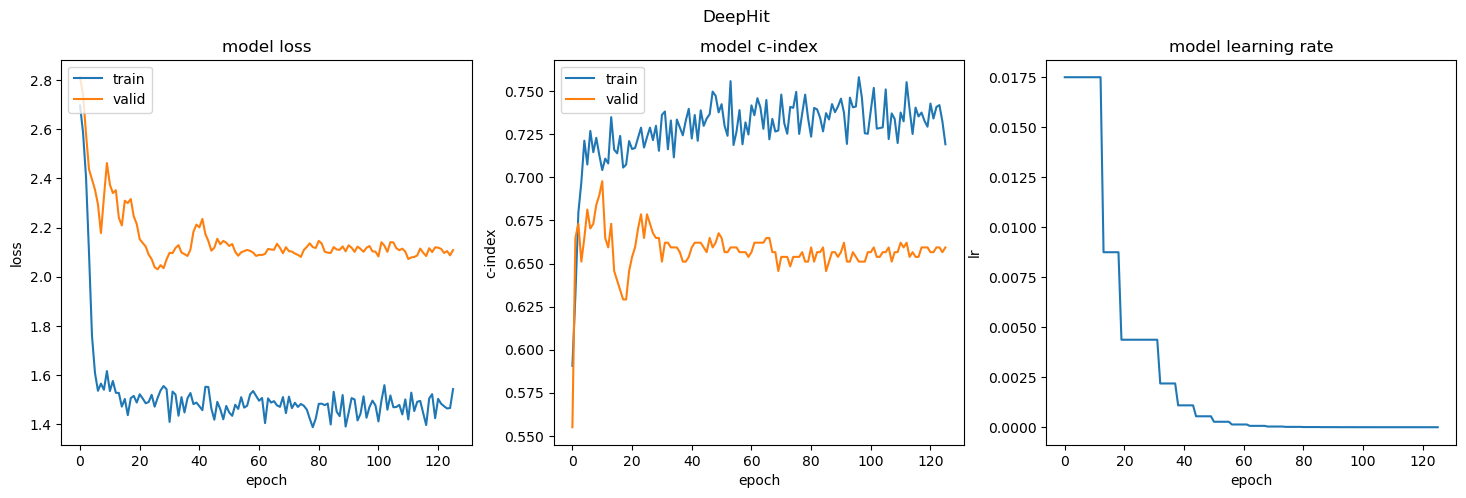

Trial name,c_index,date,done,episodes_total,experiment_id,experiment_tag,hostname,iterations_since_restore,loss,node_ip,pid,time_since_restore,time_this_iter_s,time_total_s,timestamp,timesteps_since_restore,timesteps_total,training_iteration,trial_id,warmup_time
train_surv_102f8_00000,0.68422,2023-05-20_09-22-42,True,,245896323b3b4afc88527fd2c69c5d42,"0_batch_size=99999,dropout=0.2994,layer_size=64,lr=0.0553,missing_values_strategy=drop,num_layers=6,weight_decay=0.0018",DESKTOP-670FM4Q,1,4.26014,127.0.0.1,1376,14.1947,14.1947,14.1947,1684567362,0,,1,102f8_00000,0.00499916


2023-05-20 09:22:54,485	INFO tune.py:798 -- Total run time: 31.69 seconds (31.65 seconds for the tuning loop).


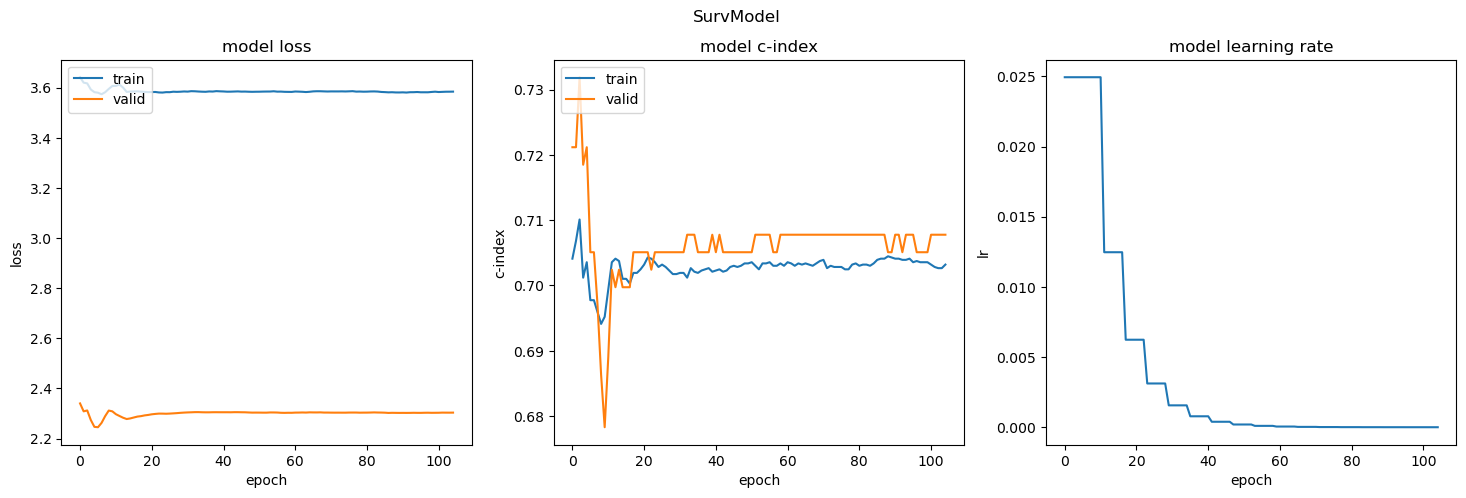

Dataset: get_veterans_lugn_cancer, hit best config {'lr': 0.017496980159322658, 'dropout': 0.11231337315728025, 'layer_size': 16, 'num_layers': 10, 'weight_decay': 0.0003378406014472881, 'time_bins': 50, 'interpolation_steps': 10, 'batch_size': 32, 'missing_values_strategy': 'mean'}, surv best config {'lr': 0.024939997791803264, 'dropout': 0.4625663769166395, 'layer_size': 32, 'num_layers': 4, 'weight_decay': 0.00034512070343009345, 'batch_size': 512, 'missing_values_strategy': 'median'}
hit concordance 0.6730769230769231, surv concordance 0.7050938337801609, cph concordance 0.6813186813186813


2023-05-20 09:26:10,213	INFO tune.py:798 -- Total run time: 194.21 seconds (194.17 seconds for the tuning loop).


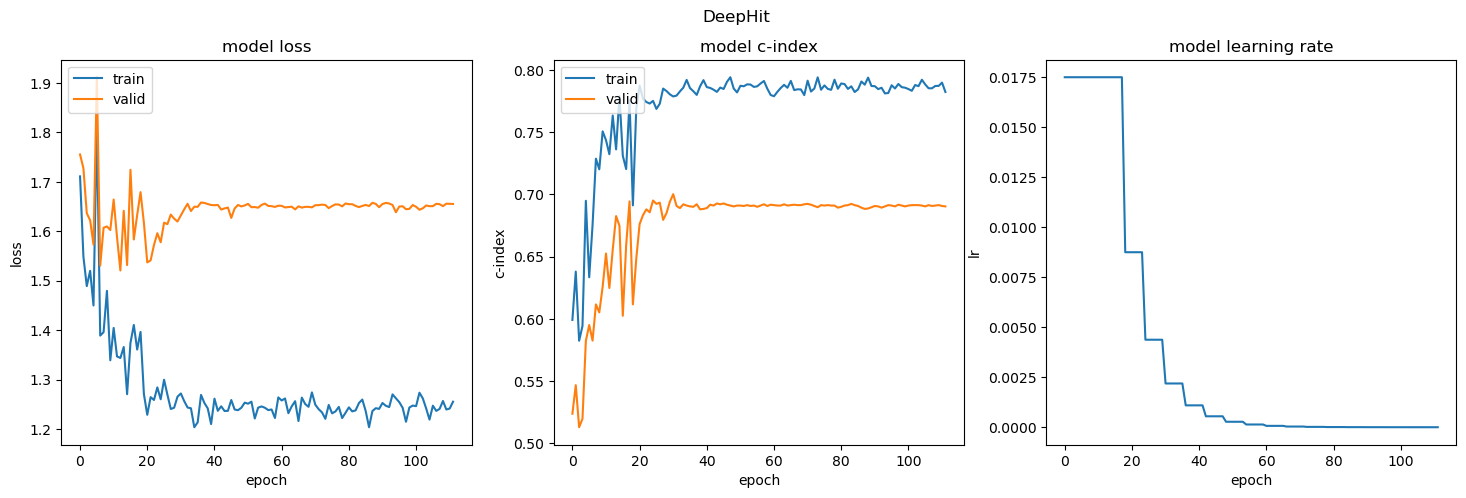

2023-05-20 09:27:05,175	INFO tune.py:798 -- Total run time: 36.89 seconds (36.86 seconds for the tuning loop).


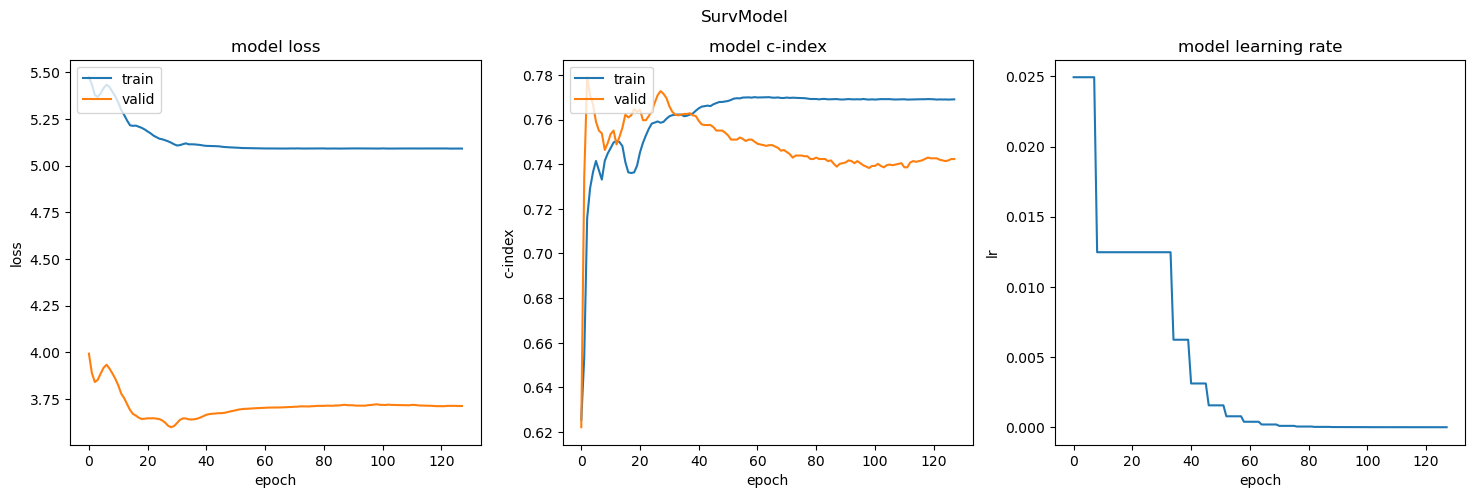

Dataset: get_whas500, hit best config {'lr': 0.017496980159322658, 'dropout': 0.11231337315728025, 'layer_size': 16, 'num_layers': 10, 'weight_decay': 0.0003378406014472881, 'time_bins': 50, 'interpolation_steps': 10, 'batch_size': 32, 'missing_values_strategy': 'mean'}, surv best config {'lr': 0.024939997791803264, 'dropout': 0.4625663769166395, 'layer_size': 32, 'num_layers': 4, 'weight_decay': 0.00034512070343009345, 'batch_size': 512, 'missing_values_strategy': 'median'}
hit concordance 0.6555217831813577, surv concordance 0.7714995343061161, cph concordance 0.7190138466734212


2023-05-20 09:33:01,476	INFO tune.py:798 -- Total run time: 353.04 seconds (353.00 seconds for the tuning loop).


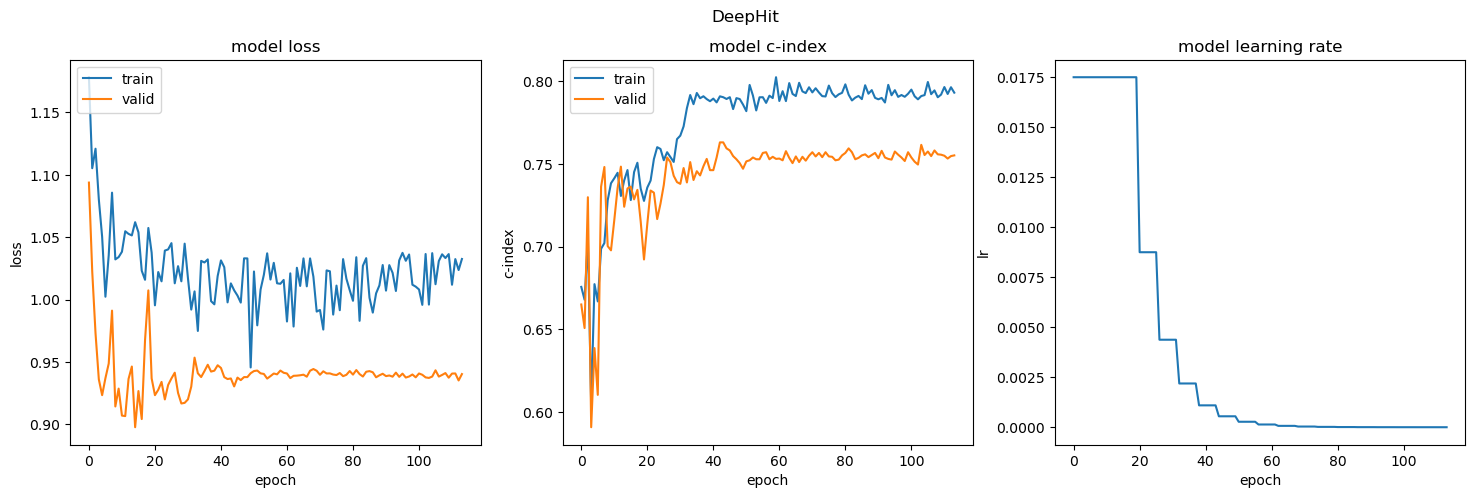

2023-05-20 09:34:14,392	INFO tune.py:798 -- Total run time: 35.97 seconds (35.94 seconds for the tuning loop).


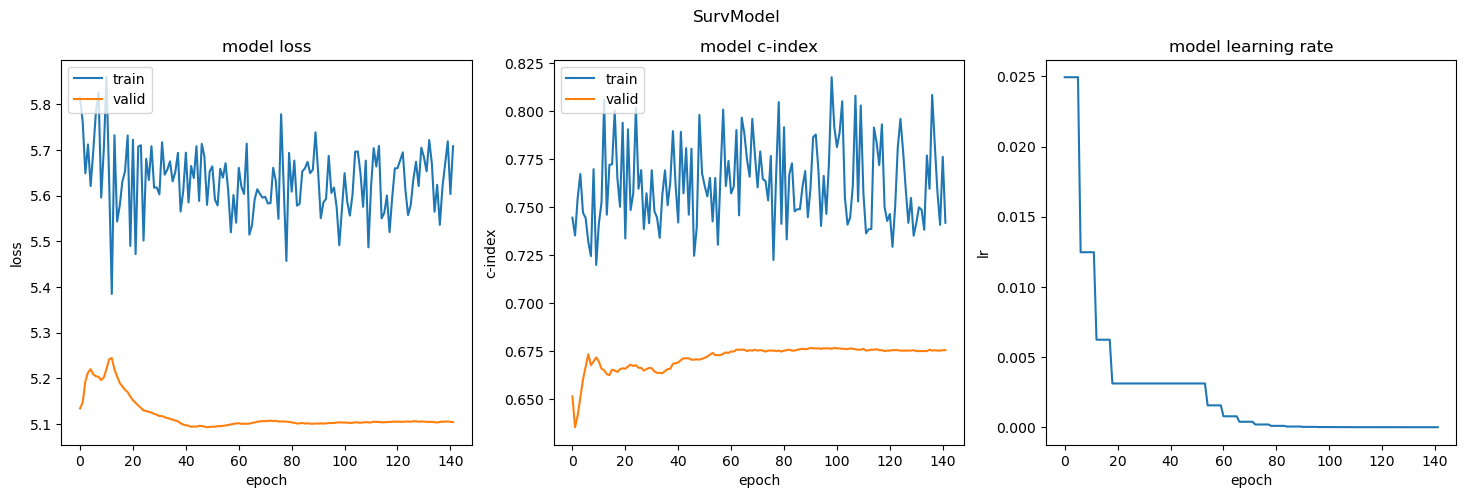

Dataset: get_aids, hit best config {'lr': 0.017496980159322658, 'dropout': 0.11231337315728025, 'layer_size': 16, 'num_layers': 10, 'weight_decay': 0.0003378406014472881, 'time_bins': 50, 'interpolation_steps': 10, 'batch_size': 32, 'missing_values_strategy': 'mean'}, surv best config {'lr': 0.024939997791803264, 'dropout': 0.4625663769166395, 'layer_size': 32, 'num_layers': 4, 'weight_decay': 0.00034512070343009345, 'batch_size': 512, 'missing_values_strategy': 'median'}
hit concordance 0.7351190476190477, surv concordance 0.6711552090715804, cph concordance 0.7302295918367347


2023-05-20 09:38:12,555	INFO tune.py:798 -- Total run time: 234.46 seconds (234.43 seconds for the tuning loop).


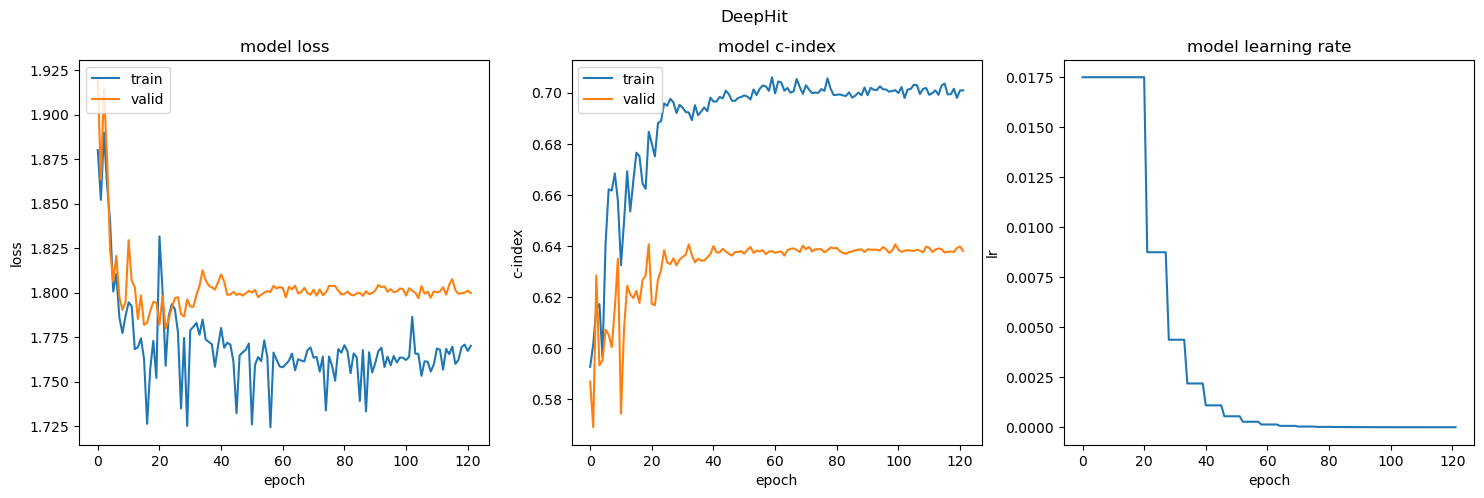

2023-05-20 09:39:22,608	INFO tune.py:798 -- Total run time: 42.82 seconds (42.79 seconds for the tuning loop).


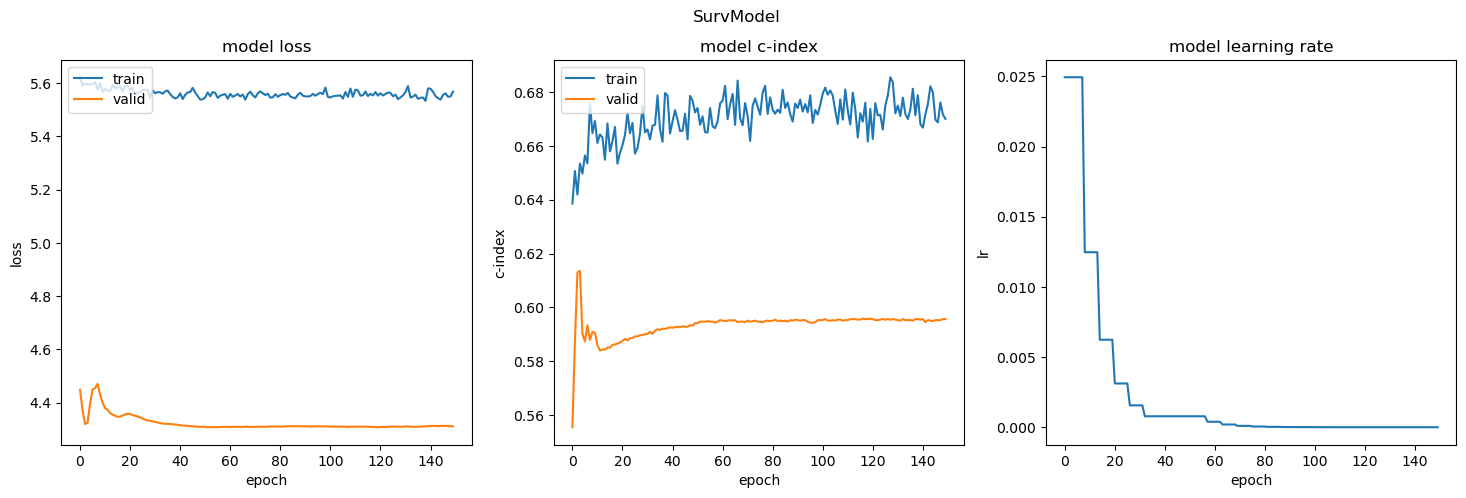

Dataset: get_gbsg2, hit best config {'lr': 0.017496980159322658, 'dropout': 0.11231337315728025, 'layer_size': 16, 'num_layers': 10, 'weight_decay': 0.0003378406014472881, 'time_bins': 50, 'interpolation_steps': 10, 'batch_size': 32, 'missing_values_strategy': 'mean'}, surv best config {'lr': 0.024939997791803264, 'dropout': 0.4625663769166395, 'layer_size': 32, 'num_layers': 4, 'weight_decay': 0.00034512070343009345, 'batch_size': 512, 'missing_values_strategy': 'median'}
hit concordance 0.626770538243626, surv concordance 0.5956685499058381, cph concordance 0.6680240793201133


2023-05-20 09:53:12,557	INFO tune.py:798 -- Total run time: 826.00 seconds (825.97 seconds for the tuning loop).


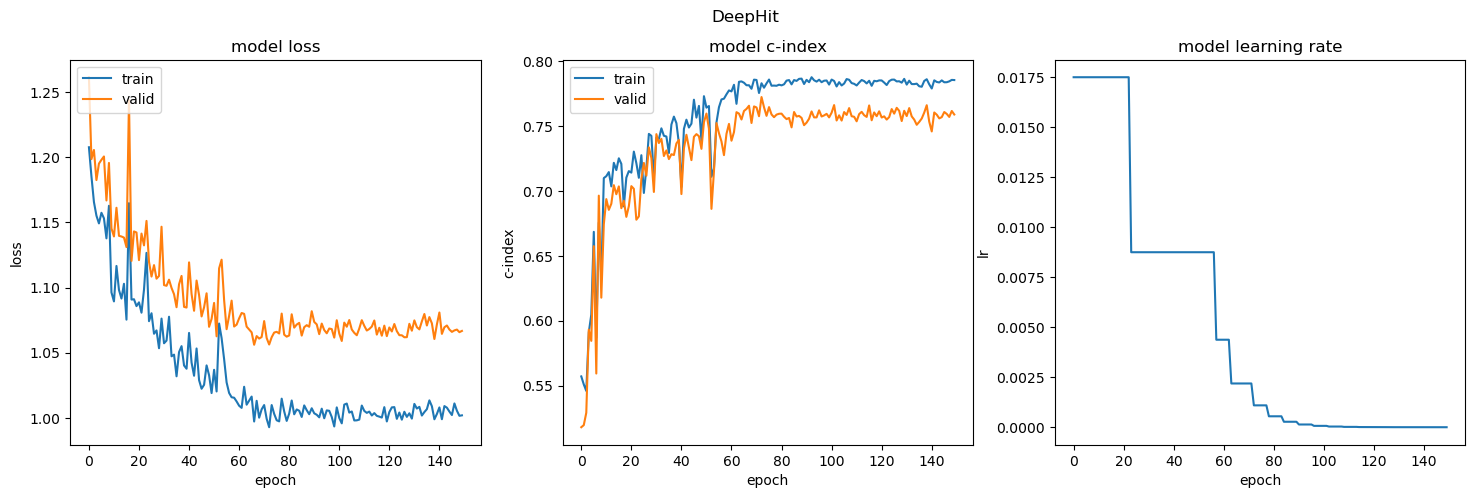

2023-05-20 09:56:29,565	INFO tune.py:798 -- Total run time: 96.96 seconds (96.92 seconds for the tuning loop).


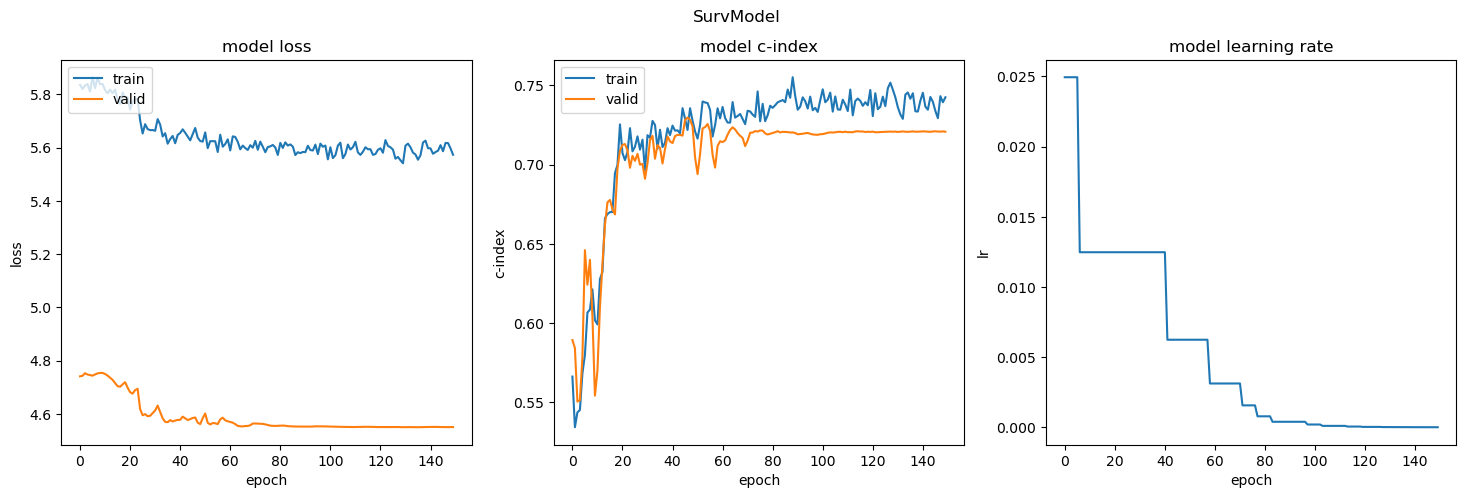

Dataset: get_metabric, hit best config {'lr': 0.017496980159322658, 'dropout': 0.11231337315728025, 'layer_size': 16, 'num_layers': 10, 'weight_decay': 0.0003378406014472881, 'time_bins': 50, 'interpolation_steps': 10, 'batch_size': 32, 'missing_values_strategy': 'mean'}, surv best config {'lr': 0.024939997791803264, 'dropout': 0.4625663769166395, 'layer_size': 32, 'num_layers': 4, 'weight_decay': 0.00034512070343009345, 'batch_size': 512, 'missing_values_strategy': 'median'}
hit concordance 0.760385928848513, surv concordance 0.7207018819892718, cph concordance 0.7100891880242698


2023-05-20 10:30:39,676	INFO tune.py:798 -- Total run time: 2039.60 seconds (2039.57 seconds for the tuning loop).


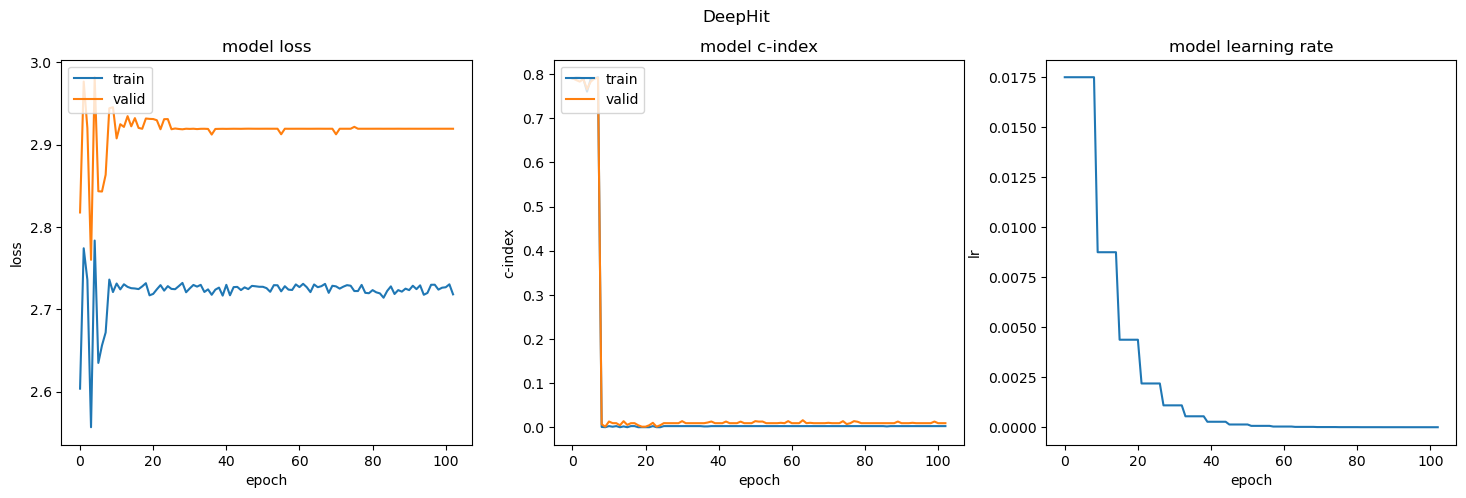

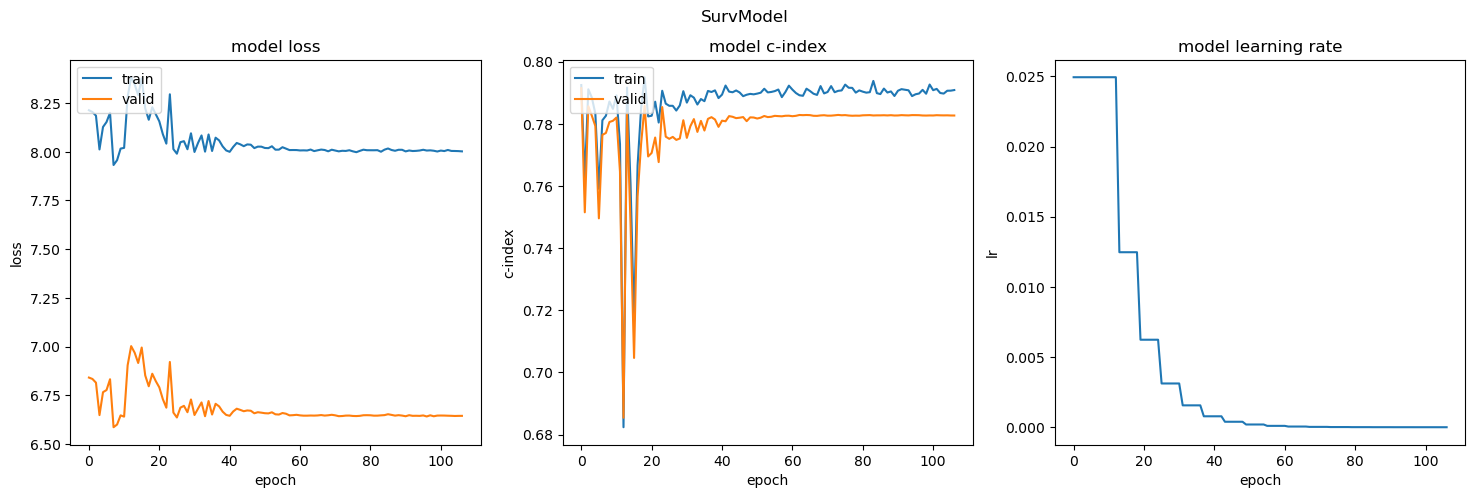

Dataset: get_flchain, hit best config {'lr': 0.017496980159322658, 'dropout': 0.11231337315728025, 'layer_size': 16, 'num_layers': 10, 'weight_decay': 0.0003378406014472881, 'time_bins': 50, 'interpolation_steps': 10, 'batch_size': 32, 'missing_values_strategy': 'mean'}, surv best config {'lr': 0.024939997791803264, 'dropout': 0.4625663769166395, 'layer_size': 32, 'num_layers': 4, 'weight_decay': 0.00034512070343009345, 'batch_size': 512, 'missing_values_strategy': 'median'}
hit concordance 0.7884006575284951, surv concordance 0.7770547925901012, cph concordance 0.8003328878584027


In [54]:
df_functions = [utils.get_veterans_lugn_cancer, utils.get_whas500, utils.get_aids, utils.get_gbsg2, utils.get_metabric, utils.get_flchain]
for df_func in df_functions:
    
    tuner_hit = tune.Tuner(
        train_hit,
        tune_config=tune.TuneConfig(
            metric="c_index",
            mode="max",
            num_samples=3,
            max_concurrent_trials=8
        ),
        param_space=hit_config
    )
    analysis_hit = tuner_hit.fit()

    df, event_col, duration_col  = df_func(missing_values_strategy=hit_config["missing_values_strategy"])
    df_train, df_test = utils.split_dataset(df)

    train_index = df_train.index.values
    test_index = df_test.index.values

    
    hit_config = analysis_hit.get_best_result(metric="c_index", mode="max", scope="all").config
    hit_model = DeepHitModel(df.copy(), events_col=event_col, time_col=duration_col, time_bins=TIME_BINS, interpolation_steps=hit_config["interpolation_steps"]
                                 , layers = [hit_config["layer_size"]] * hit_config["num_layers"], dropout=hit_config["dropout"], residual=True, batch_size=hit_config["batch_size"])
    history = hit_model.fit(epochs=150, train_index=train_index, valid_index=test_index, lr=hit_config["lr"], verbose=False, track_history=True, weight_decay=hit_config["weight_decay"])
    utils.plot_history(history, 'DeepHit')
    hit_oof = hit_model.concordance_index(hit_model.predict(test_index), (torch.tensor(hit_model.x[test_index]), torch.tensor(hit_model.events[test_index]),
                                           torch.tensor(hit_model.time[test_index]), torch.tensor(hit_model.continous_time[test_index]), hit_model.mask[test_index]))
    tuner_surv = tune.Tuner(
        train_surv,
        tune_config=tune.TuneConfig(
            metric="c_index",
            mode="max",
            num_samples=3,
            max_concurrent_trials=8
        ),
        param_space=surv_config
    )
    analysis_surv = tuner_surv.fit()

    surv_config = analysis_surv.get_best_result(metric="c_index", mode="max", scope="all").config
    model = SurvModel(df.copy(), events_col=event_col, time_col=duration_col, layers = [surv_config["layer_size"]] * surv_config["num_layers"], dropout=surv_config["dropout"],
                            residual=True, batch_size=surv_config["batch_size"])
    history = model.fit(epochs=150, train_index=train_index, valid_index=test_index, lr=surv_config["lr"], verbose=False, track_history=True, weight_decay=surv_config["weight_decay"])
    utils.plot_history(history, 'SurvModel')
    surv_oof = model.concordance_index(model.predict(test_index),( torch.tensor(model.x[test_index]),
                                        torch.tensor(model.events[test_index]), torch.tensor(model.time[test_index])))
    cph = CoxPHFitter(penalizer=0.1)

    cph.fit(df_train, duration_col = duration_col, event_col = event_col)
    concordance_index = cph.score(df_test, scoring_method="concordance_index")

    print(f'Dataset: {df_func.__name__}, hit best config {hit_config}, surv best config {surv_config}')
    print(f'hit concordance {hit_oof}, surv concordance {surv_oof}, cph concordance {concordance_index}')
    

In [20]:
df, event_col, duration_col  = df_func(missing_values_strategy=hit_config["missing_values_strategy"])
df_train, df_test = utils.split_dataset(df)
#get test index of df_test from df
test_index = df.index[df.isin(df_test).all(1)]
test_index

Int64Index([  25,   29,   43,   44,   48,   49,   51,   56,   67,   69,
            ...
            1550, 1551, 1557, 1563, 1567, 1572, 1627, 1672, 1700, 1743],
           dtype='int64', length=248)

In [51]:
analysis_surv.get_best_result(metric="c_index", mode="max", scope="all").config

2023-05-20 09:18:01,898	WARNING experiment_analysis.py:621 -- Could not find best trial. Did you pass the correct `metric` parameter?


Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "C:\Users\User\AppData\Roaming\Python\Python310\site-packages\IPython\core\interactiveshell.py", line 3433, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\User\AppData\Local\Temp\ipykernel_11496\2955434359.py", line 1, in <module>
    analysis_surv.get_best_result(metric="c_index", mode="max", scope="all").config
  File "d:\Users\User\anaconda3\envs\SurvAnalysis\lib\site-packages\ray\tune\result_grid.py", line 134, in get_best_result
    raise RuntimeError(error_msg)
RuntimeError: No best trial found for the given metric: c_index. This means that no trial has reported this metric, or all values reported for this metric are NaN. To not ignore NaN values, you can set the `filter_nan_and_inf` arg to False.

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\User\AppData\Roaming\Python\Python310\site-packages\IPython\core\interactiveshell.py", 

In [22]:
df

,Age at Diagnosis,Cohort,Neoplasm Histologic Grade,Lymph nodes examined positive,Mutation Count,Nottingham prognostic index,Overall Survival (Months),Tumor Size,Tumor Stage,Censorship,Type of Breast Surgery_MASTECTOMY,Cellularity_Low,Cellularity_Moderate,Chemotherapy_YES,Pam50 + Claudin-low subtype_Basal,Pam50 + Claudin-low subtype_Her2,Pam50 + Claudin-low subtype_LumA,Pam50 + Claudin-low subtype_LumB,Pam50 + Claudin-low subtype_Normal,Pam50 + Claudin-low subtype_claudin-low,ER status measured by IHC_Positve,ER Status_Positive,HER2 status measured by SNP6_GAIN,HER2 status measured by SNP6_LOSS,HER2 status measured by SNP6_NEUTRAL,HER2 Status_Positive,Hormone Therapy_YES,Inferred Menopausal State_Pre,Integrative Cluster_10,Integrative Cluster_2,Integrative Cluster_3,Integrative Cluster_4ER+,Integrative Cluster_4ER-,Integrative Cluster_5,Integrative Cluster_6,Integrative Cluster_7,Integrative Cluster_8,Integrative Cluster_9,Primary Tumor Laterality_Right,PR Status_Positive,Radio Therapy_YES,3-Gene classifier subtype_ER+/HER2- Low Prolif,3-Gene classifier subtype_ER-/HER2-,3-Gene classifier subtype_HER2+
0,75.65,1.0,3.0,10.0,NaN,6.044,140.500000,22.0,2.0,True,1,0,0,0,0,0,0,0,0,1,1,1,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,1,0
1,43.19,1.0,3.0,0.0,2.0,4.020,84.633333,10.0,1.0,True,0,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,1,1,0,0,0,1,0,0,0,0,0,0,1,1,1,0,0,0
2,48.87,1.0,2.0,1.0,2.0,4.030,163.700000,15.0,2.0,False,1,0,0,1,0,0,0,1,0,0,1,1,0,0,1,0,1,1,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0
3,47.68,1.0,2.0,3.0,1.0,4.050,164.933333,25.0,2.0,True,1,0,1,1,0,0,0,1,0,0,1,1,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0
4,76.97,1.0,3.0,8.0,2.0,6.080,41.366667,40.0,2.0,False,1,0,0,1,0,0,0,1,0,0,1,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2504,70.05,1.0,1.0,0.0,2.0,2.540,NaN,27.0,1.0,False,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2505,63.60,1.0,2.0,0.0,4.0,4.560,NaN,28.0,2.0,False,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2506,NaN,NaN,NaN,0.0,6.0,NaN,NaN,NaN,0.0,False,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2507,NaN,NaN,NaN,0.0,7.0,NaN,NaN,NaN,0.0,False,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
analysis_surv = tune.run(
    train_surv,
    config=surv_config,
    num_samples=300,
    resources_per_trial={"cpu": 1, "gpu": 0},
    metric="c_index",
    mode="max",
    name="surv",
    local_dir="~/ray_results"
)
print(f'best score{analysis_surv.get_best_trial(metric="c_index", mode="max").last_result["c_index"]}, best config {analysis_surv.get_best_trial(metric="c_index", mode="max").config}')

2023-05-13 14:59:56,923	ERROR worker.py:399 -- Unhandled error (suppress with 'RAY_IGNORE_UNHANDLED_ERRORS=1'): ray::ImplicitFunc.train() (pid=1916, ip=127.0.0.1, repr=train_surv)
  File "python\ray\_raylet.pyx", line 857, in ray._raylet.execute_task
  File "python\ray\_raylet.pyx", line 861, in ray._raylet.execute_task
  File "python\ray\_raylet.pyx", line 803, in ray._raylet.execute_task.function_executor
  File "d:\Users\User\anaconda3\envs\SurvAnalysis\lib\site-packages\ray\_private\function_manager.py", line 674, in actor_method_executor
    return method(__ray_actor, *args, **kwargs)
  File "d:\Users\User\anaconda3\envs\SurvAnalysis\lib\site-packages\ray\util\tracing\tracing_helper.py", line 466, in _resume_span
    return method(self, *_args, **_kwargs)
  File "d:\Users\User\anaconda3\envs\SurvAnalysis\lib\site-packages\ray\tune\trainable\trainable.py", line 368, in train
    raise skipped from exception_cause(skipped)
  File "d:\Users\User\anaconda3\envs\SurvAnalysis\lib\site-p

Trial name,date,experiment_id,hostname,node_ip,pid,timestamp,trial_id
train_surv_f87ce_00000,2023-05-13_14-59-27,fbcee8d5ad4d4bf0960c15734d7f25f2,DESKTOP-670FM4Q,127.0.0.1,21352,1683982767,f87ce_00000
train_surv_f87ce_00001,2023-05-13_14-59-33,d6222678cc2d4a8aa05d4a2ecd600e63,DESKTOP-670FM4Q,127.0.0.1,9080,1683982773,f87ce_00001
train_surv_f87ce_00002,2023-05-13_14-59-39,1d56b4d9325c48cc98304dc5424f635a,DESKTOP-670FM4Q,127.0.0.1,16808,1683982779,f87ce_00002
train_surv_f87ce_00003,2023-05-13_14-59-45,527d8cd8d66e47059adbe110421cee9f,DESKTOP-670FM4Q,127.0.0.1,22848,1683982785,f87ce_00003
train_surv_f87ce_00004,2023-05-13_14-59-51,ee73f935b7c14540a6cd96b57b923010,DESKTOP-670FM4Q,127.0.0.1,1916,1683982791,f87ce_00004
train_surv_f87ce_00005,2023-05-13_14-59-57,0b466e334c4c499e9cdebe6cd64c1816,DESKTOP-670FM4Q,127.0.0.1,35392,1683982797,f87ce_00005
train_surv_f87ce_00006,2023-05-13_15-00-03,92082faba6ac42e180f8f26e4b54783e,DESKTOP-670FM4Q,127.0.0.1,13352,1683982803,f87ce_00006
train_surv_f87ce_00007,2023-05-13_15-00-09,94e7cca3f574467189a2a2f5ef4f7dd8,DESKTOP-670FM4Q,127.0.0.1,17276,1683982809,f87ce_00007
train_surv_f87ce_00008,2023-05-13_15-00-16,a01eedaf48f74ba7b00b56145c6f56aa,DESKTOP-670FM4Q,127.0.0.1,25708,1683982816,f87ce_00008
train_surv_f87ce_00009,2023-05-13_15-00-23,5428786ca5014f5daa1f49a76bd03a0e,DESKTOP-670FM4Q,127.0.0.1,35388,1683982823,f87ce_00009


Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "C:\Users\User\AppData\Roaming\Python\Python310\site-packages\IPython\core\interactiveshell.py", line 3433, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\User\AppData\Local\Temp\ipykernel_33388\2158575436.py", line 1, in <module>
    analysis_surv = tune.run(
  File "d:\Users\User\anaconda3\envs\SurvAnalysis\lib\site-packages\ray\tune\tune.py", line 792, in run
    raise TuneError("Trials did not complete", incomplete_trials)
ray.tune.error.TuneError: ('Trials did not complete', [train_surv_f87ce_00000, train_surv_f87ce_00001, train_surv_f87ce_00002, train_surv_f87ce_00003, train_surv_f87ce_00004, train_surv_f87ce_00005, train_surv_f87ce_00006, train_surv_f87ce_00007, train_surv_f87ce_00008, train_surv_f87ce_00009, train_surv_f87ce_00010, train_surv_f87ce_00011, train_surv_f87ce_00012, train_surv_f87ce_00013, train_surv_f87ce_00014, train_surv_f87ce_00015, train_surv_f87ce_00016, train_surv_f87ce_00017, trai